In [193]:
import os
import pickle

import pandas as pd
import numpy as np
import tqdm
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

import gensim
import nltk
import textdistance
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr, kendalltau, spearmanr
from itertools import permutations, product, combinations
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind, ttest_rel
from scipy.spatial.distance import cosine
from IPython.display import display, Markdown, Latex
import time
from scipy.special import kl_div
from scipy.stats import binomtest
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Importing custom functions
import rsa_utils
import data_utils


In [194]:
df = pd.read_excel('E:/NOUN-NOUN-COMPOUNDS-V1/data/noun_noun_compounds/nn_compounds.xlsx', skiprows=9)
df = df[~df["NN sentence"].isnull()]

In [195]:
corr_metric = 'kendalltau'

order_dict = dict(zip(['roberta-base' , 'bert-base-japanese' , 'openai-community/gpt2', 'microsoft/phi-1', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'meta-llama/Llama-3.2-3B'], range(0, 6)))
model_name_map = {'roberta-base': 'RoBERTa', 'bert-base-japanese' : 'BERT-Japanese' , 'openai-community/gpt2': 'GPT-2-small', 'microsoft/phi-1' : 'Phi', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B': 'DeepSeek', 
                  'meta-llama/Llama-3.2-3B': 'LLaMA-3.2-3B'}

def sort_df_by_model_order(df, keep_order_col=True, update_names=True):
    df['model_order'] = [order_dict[x.model] for x in df.iloc]
    
    extra_columns_to_sort = ['representation', 'Word representations processed . . .']
    extra_columns_to_sort = [x for x in extra_columns_to_sort if x in df.columns]
    
    sort_cols = ['model_order'] + extra_columns_to_sort
    df = df.sort_values(sort_cols)    
    
    if not keep_order_col:
        del df['model_order']
   
    if update_names:
        df['model_name'] = [model_name_map[x.model] for x in df.iloc]
        if 'representation' in df.columns:
            df['representation_name'] = [model_name_map[x.representation] if x.representation in model_name_map else x.representation for x in df.iloc]
            
    return df

In [196]:
def get_processed_sentence(word, original_sent, head_word=True):
    if head_word and 'They are' in original_sent:
        return 'They are ' + word
    if 'It is a' not in original_sent and 'They are' not in original_sent:
        return 'It is ' + word
    if word[0] in ['a', 'e', 'u', 'i', 'o']:
        return 'It is an ' + word
    else: 
        return 'It is a ' + word


full_sents = df['NN sentence'][:300].tolist()

words_per_sent = [x.split(' ') for x in full_sents]

raw_mod_word_sents = ['{}\t{}'.format(words[-2], get_processed_sentence(words[-2], full, False)) for words, full in zip(words_per_sent, full_sents)]
raw_head_word_sents = ['{}\t{}'.format(words[-1][:-1], get_processed_sentence(words[-1], full, True)[:-1]) for words, full in zip(words_per_sent, full_sents)]

flat_list = [item for sublist in list(zip(raw_mod_word_sents, raw_head_word_sents)) for item in sublist]

file = open('E:/NOUN-NOUN-COMPOUNDS-V1/data/noun_noun_compounds/composition/probe_words_and_sentences_300_raw.txt', 'w')
for i, sent in enumerate(flat_list):
    file.write(sent + '\n')

def any_sentences_are_different(sentences):
    results = [[sent_a == sent_b for sent_b in sentences] for sent_a in sentences]
    return any([not all(x) for x in results])

any_sentences_are_different(['This is a test!', 'This is a test!', 'This is a test!'])

False

In [197]:
sentences = np.array(df['NN sentence'][:300].tolist() + df['Gloss sentence'].tolist())

df['compound'] = ['{} {}'.format(x['mod'], x['head']) for x in df.iloc]
compounds = np.array(df['compound'][:300].tolist() + df['compound'].tolist())

process_sent = lambda x: [y for y in nltk.word_tokenize(x.strip().lower()) if y.isalpha()]

lemmatiser = WordNetLemmatizer()

word_dict = {'gestates': "gestate"}
look_up = lambda word: word_dict[word] if word in word_dict else lemmatiser.lemmatize(word)
get_vector = lambda word: fasttext.wv[word] if word in fasttext.wv else fasttext.wv[look_up(word)] 

def get_average_vector(words):
    return np.vstack([get_vector(x) for x in words]).mean(axis=0)

paraphrase_ind_tuples = [[i, i+300, i+600] for i in range(300)]
paraphrase_inds = [item for sublist in paraphrase_ind_tuples for item in sublist]

ordered_sentences = sentences[paraphrase_inds]

# Keep True because this file exists
load = True

if not load:
    fasttext = gensim.models.KeyedVectors.load_word2vec_format('E:/NOUN-NOUN-COMPOUNDS-V1/data/fasttext/wiki_en/wiki.en.vec', limit=500000)
    mean_fasttext_reps_per_sent = np.vstack([get_average_vector(x) for x in words_per_sent])
    ordered_fasttext_reps = mean_fasttext_reps_per_sent[paraphrase_inds]
    np.save('E:/NOUN-NOUN-COMPOUNDS-V1/data/ordered_fasttext_reps.npy', ordered_fasttext_reps)
else:
    ordered_fasttext_reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/ordered_fasttext_reps.npy')

SignificanceResult(statistic=0.06652617458246601, pvalue=0.0)

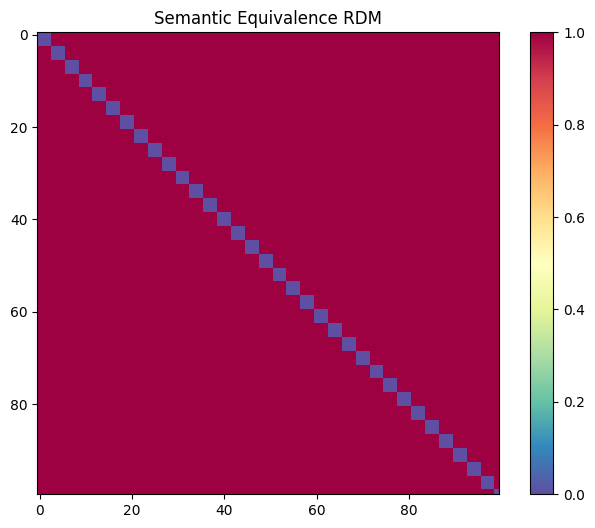

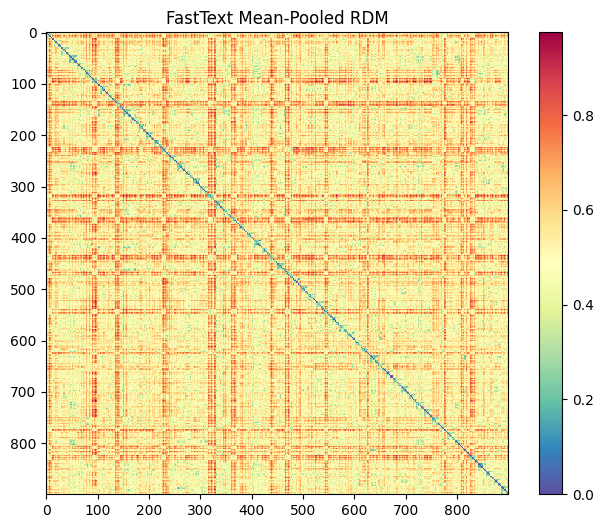

In [198]:
paraphrase_identity_rdm = np.ones((900, 900))
paraphrase_identity_rdm[np.arange(900), np.arange(900)] = 0

for x in range(0, 300):
    paraphrase_identity_rdm[x*3:x*3+3, x*3:x*3+3] = 0
    
# rsa_utils.plot_mtx(paraphrase_identity_rdm, 'Semantic Equivalence RDM')
rsa_utils.plot_mtx(paraphrase_identity_rdm[:100, :100], 'Semantic Equivalence RDM')

ordered_fasttext_mean_rdm = rsa_utils.get_rdm(ordered_fasttext_reps, 'cosine')
rsa_utils.plot_mtx(ordered_fasttext_mean_rdm, 'FastText Mean-Pooled RDM')

rsa_utils.correlate_rdms(paraphrase_identity_rdm, ordered_fasttext_mean_rdm, correlation=corr_metric)

Ratcliff-Obershelp similarity


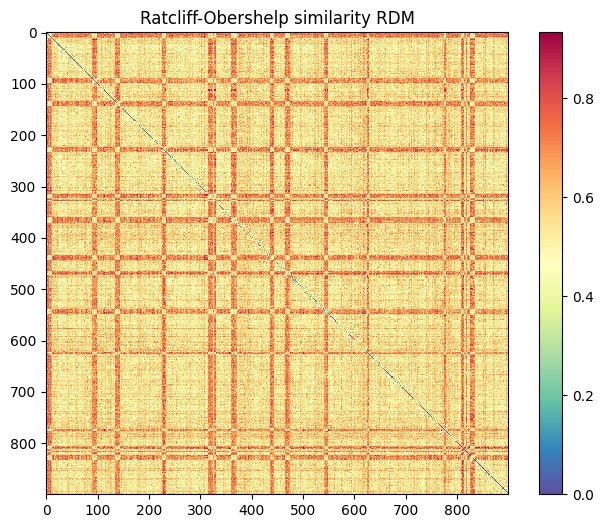

SignificanceResult(statistic=0.04904835721376136, pvalue=0.0)
Monge-Elkan


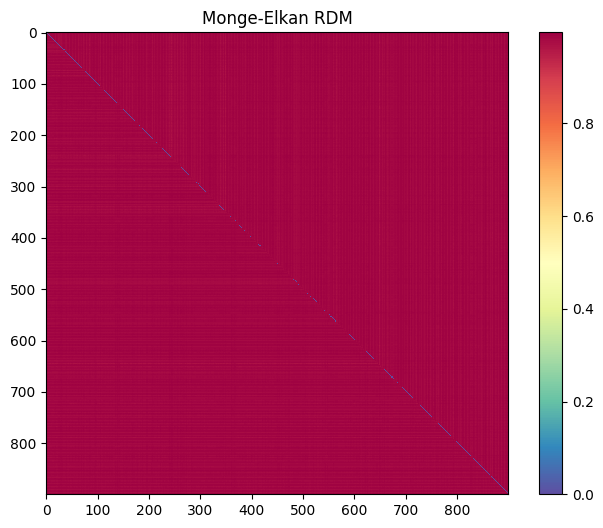

SignificanceResult(statistic=-0.006423717265369589, pvalue=5.870452992875178e-07)
Levenshtein


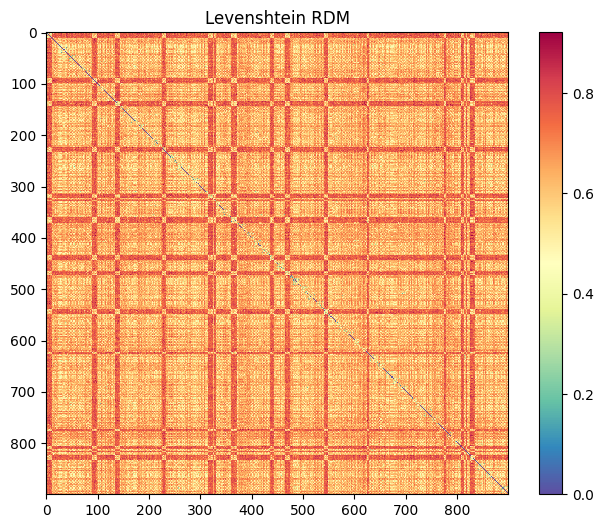

SignificanceResult(statistic=0.0322948664417737, pvalue=9.593246123222248e-139)
Jaccard index


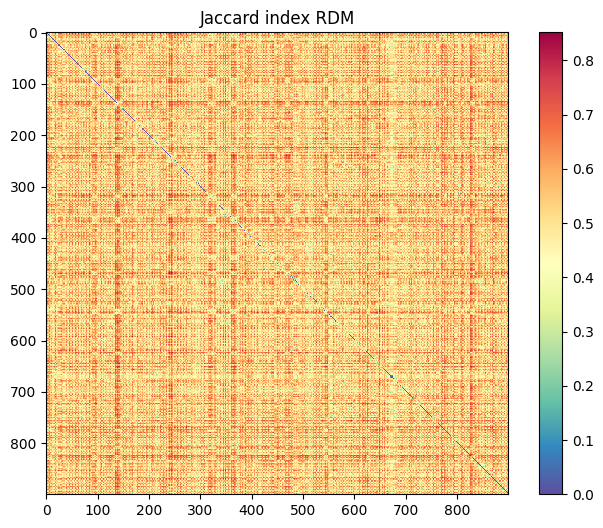

SignificanceResult(statistic=0.04511400881427962, pvalue=3.6824296941936564e-269)


In [199]:
text_distance_features = [('Ratcliff-Obershelp similarity', textdistance.ratcliff_obershelp), ('Monge-Elkan', textdistance.monge_elkan), ('Levenshtein', textdistance.levenshtein),
                         ('Jaccard index', textdistance.jaccard)]

# These RDMs exist so keep true
load = True

rdm_dict = {}

for (distance_name, distance_func) in text_distance_features:
    print(distance_name)
    
    if not load:
        rdm = np.zeros((900, 900))
        for (i, j) in tqdm.tqdm([(i, j) for i in range(900) for j in range(900)]):
            if i >= j:
                dist = distance_func.normalized_distance(ordered_sentences[i], ordered_sentences[j])
                rdm[i, j] = dist
                rdm[j, i] = dist
    else:
        rdm = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/rdms/{}.npy'.format(distance_name))
    rsa_utils.plot_mtx(rdm, distance_name + ' RDM')
    plt.show()
    print(rsa_utils.correlate_rdms(paraphrase_identity_rdm, rdm, correlation=corr_metric))
    rdm_dict[distance_name] = rdm


jaccard_rdm = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/files/Jaccard index.npy')
monge_elkan_rdm = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/files/Monge-Elkan.npy')
ratcliff_obershelp_rdm = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/files/Ratcliff-Obershelp similarity.npy')
levenshtein_rdm = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/files/Levenshtein.npy')

In [200]:

model_names = ["roberta-base", "bert-base-japanese", "openai-community/gpt2", "microsoft/phi-1", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", "meta-llama/Llama-3.2-3B"]
print(model_names)

['roberta-base', 'bert-base-japanese', 'openai-community/gpt2', 'microsoft/phi-1', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'meta-llama/Llama-3.2-3B']


In [201]:
rdms_to_correlate = [("paraphrase_identity_rdm", paraphrase_identity_rdm), ("jaccard_rdm", jaccard_rdm), ("monge_elkan_rdm", monge_elkan_rdm), 
                     ("ratcliff_obershelp_rdm", ratcliff_obershelp_rdm), ("levenshtein_rdm", levenshtein_rdm), ("fasttext_mean_rdm", ordered_fasttext_mean_rdm)]

In [202]:
compound_sentence_inds = np.arange(paraphrase_identity_rdm.shape[0]) % 3 == 0

def corr_within_compound_sentences(rdm_a, rdm_b):
    rdm_a_within_compound_sentences = rdm_a[compound_sentence_inds, :][:, compound_sentence_inds]
    rdm_b_within_compound_sentences = rdm_b[compound_sentence_inds, :][:, compound_sentence_inds]
    return corr(rdm_a_within_compound_sentences, rdm_b_within_compound_sentences)


In [203]:

def correlate_and_get_row_values(rdm_a, rdm_b, rdm_name, within_compound_sentences=True):
    row = {}
    
    corr_val, pvalue = corr(rdm_a, rdm_b)
    row['{}_corr'.format(rdm_name)] = corr_val
    row['{}_pvalue'.format(rdm_name)] = pvalue
    
    if within_compound_sentences:
        corr_val, pvalue = corr_within_compound_sentences(rdm_a, rdm_b)
        row['{}_corr_within_compound_sentences'.format(rdm_name)] = corr_val
        row['{}_pvalue_within_compound_sentences'.format(rdm_name)] = pvalue
        
    return row

In [204]:
# load = False

# if load:
#     results_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_whole_sentence_correlations_deepseek.csv')
# else:
#     rows = []

#     corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

#     for model_name in model_names:
#         print(model_name)
#         # This llama has 16 layers, phi-1 has 24 layers
#         for layer in tqdm.tqdm(range(1, 25)):

            
#             if layer > 12 and 'bert' in model_name:
#                 continue
#             elif layer > 12 and 'xlm' in model_name:
#                 continue
#             elif layer > 12 and 'xlnet' in model_name:
#                 continue
#             elif layer > 12 and 'gpt' in model_name:
#                 continue
#             elif layer > 16 and 'llama' in model_name:
#                 continue
#             elif layer > 6 and 'distil' in model_name:
#                 continue

#             reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds_mean_pooled/{}_layer_{}_noun_noun_compounds_mean_pooled.npy'.format(model_name.split('-')[0], layer, model_name, layer))
#             rdm = rsa_utils.get_rdm(reps[paraphrase_inds])
#             row = {'model': model_name, 'layer': layer}
            
#             for target_rdm_name, target_rdm in rdms_to_correlate:
#                 row = {**row, **correlate_and_get_row_values(rdm, target_rdm, target_rdm_name, within_compound_sentences=True)}
                
#             rows.append(row)

#     results_df = pd.DataFrame(rows)
#     results_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_whole_sentence_correlations_deepseek.csv')

In [205]:
a = np.array([[[1, 1], [2, 2], [3, 3]], 
              [[4, 4], [5, 5], [6, 6]], 
              [[7, 7], [8, 8], [9, 9]]])

In [206]:
load = False

if load:
    results_within_compound_groups_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_whole_sentence_correlations (within_compound_groups)_deepseek_3B.csv')
else:    
    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)

        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds_mean_pooled/{}_layer_{}_noun_noun_compounds_mean_pooled.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            rdm = rsa_utils.get_rdm(reps[paraphrase_inds])
            row = {'model': model_name, 'layer': layer}

            for target_rdm_name, target_rdm in rdms_to_correlate:
                row = {**row, **rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, corr_metric=corr_metric)}

            rows.append(row)


    results_within_compound_groups_df = pd.DataFrame(rows)
    results_within_compound_groups_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_whole_sentence_correlations (within_compound_groups)_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [02:01<00:00,  4.35s/it]


bert-base-japanese


100%|██████████| 28/28 [01:55<00:00,  4.14s/it]


openai-community/gpt2


100%|██████████| 28/28 [01:59<00:00,  4.28s/it]


microsoft/phi-1


100%|██████████| 28/28 [03:59<00:00,  8.55s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [04:33<00:00,  9.76s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [04:55<00:00, 10.54s/it]


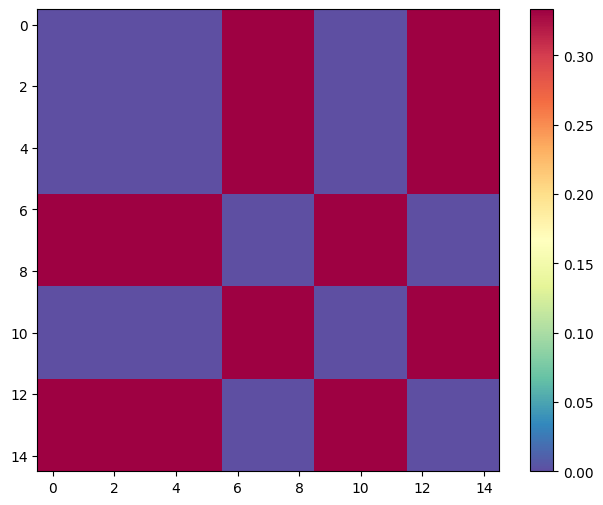

In [207]:
# Groups of five are compounds are: target, same thematic relation, different, same, different
labels_within_group = [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0] # 1 for same relation, 0 for different
same_relation_group_rdm = rsa_utils.get_rdm(np.array(labels_within_group).reshape(-1, 1))
rsa_utils.plot_mtx(same_relation_group_rdm, "")

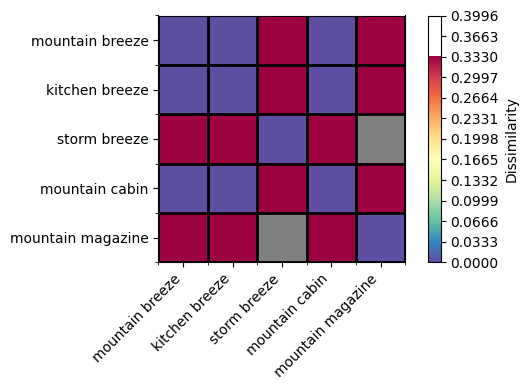

In [208]:
current_cmap = plt.get_cmap('Spectral_r')
current_cmap.set_bad(color='gray')

start = 33
sent_inds = np.arange(start * 5, start * 5 + 5)
rdm_inds = np.arange(0, 15, 3)

fig, ax = plt.subplots(figsize=(6, 4))

same_relation_group_rdm[6:9, 12:15] = np.nan
same_relation_group_rdm[12:15, 6:9] = np.nan

# plt.rcParams.update({'font.size': 12})

figure_rdm = same_relation_group_rdm[rdm_inds, :][:, rdm_inds]
plt.imshow(same_relation_group_rdm[rdm_inds, :][:, rdm_inds], interpolation='nearest', cmap=current_cmap)

cb = plt.colorbar(label='Dissimilarity')
labels = np.arange(0, 0.4, 0.0333)
cb.set_ticks(labels)
#cb.set_ticklabels(np.arange(11) / 10)

plt.xticks(ticks=np.arange(5), labels=['{}'.format(compounds[x], x) for x in sent_inds], rotation=45, ha='right');
plt.yticks(ticks=np.arange(5), labels=['{}'.format(compounds[x], x) for x in sent_inds], rotation=0, ha='right');

ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
ax.set_yticks(np.arange(-.5, 5, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
plt.tight_layout()
# plt.savefig('figures/thematic_relation_ground_truth_rdm.png', bbox_inches='tight')

# plt.savefig('figures/thematic_relation_ground_truth_rdm.eps', format='eps', bbox_inches='tight')

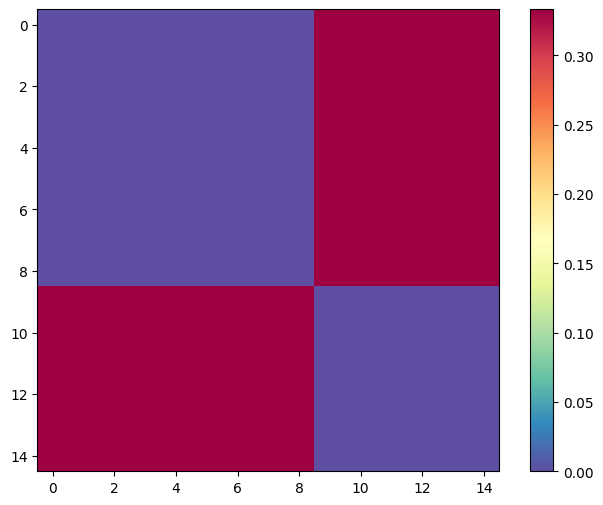

In [209]:
# Groups of five are compounds w.r.t head noun of the target are: target, same head noun, same, different, different
labels_within_group = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0] # 1 for same relation, 0 for different
same_head_rdm = rsa_utils.get_rdm(np.array(labels_within_group).reshape(-1, 1))
rsa_utils.plot_mtx(same_head_rdm, "")

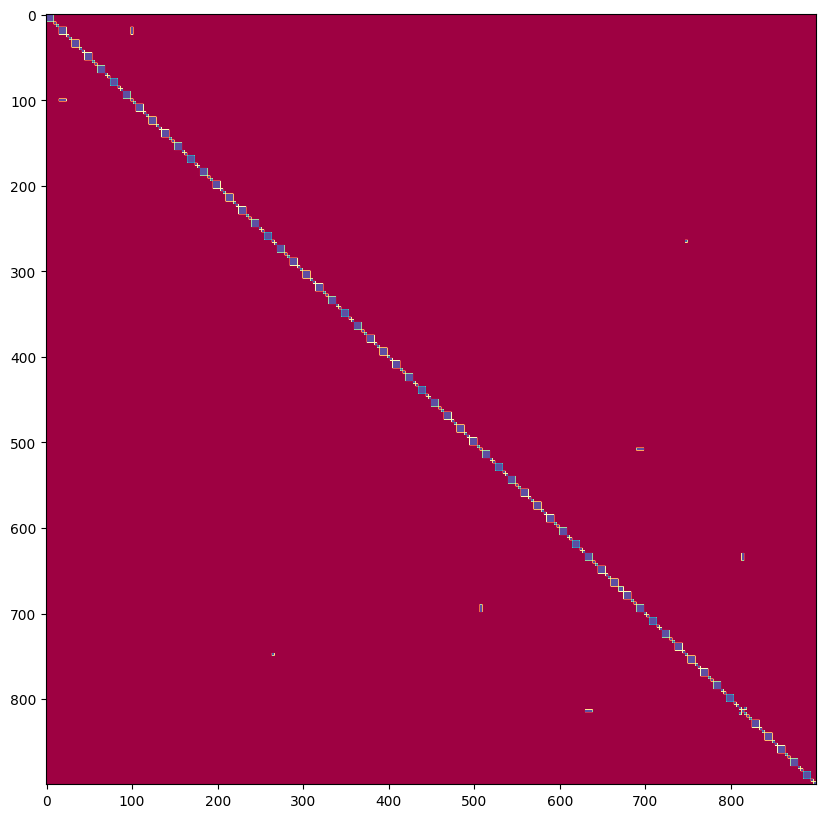

In [210]:
same_head_rdm = np.zeros((len(compounds), len(compounds)))

for i, compound_i in enumerate(compounds):
    for j, compound_j in enumerate(compounds):
        same_head_rdm[i, j] = compound_i.split(' ')[-1] != compound_j.split(' ')[-1]
        
same_head_rdm = same_head_rdm[paraphrase_inds, :][:, paraphrase_inds]

plt.figure(figsize=(10, 10))
plt.imshow(same_head_rdm, cmap='Spectral_r')

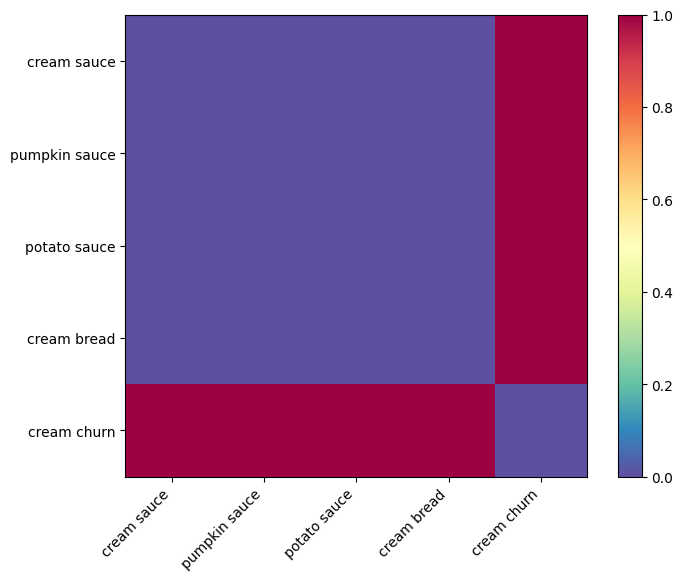

In [211]:
start = 10
sent_inds = np.arange(start * 5, start * 5 + 5)
rdm_inds = np.arange(0, 15, 3)

fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(same_head_rdm[sent_inds, :][:, sent_inds], interpolation='nearest', cmap='Spectral_r')
plt.title('')
plt.colorbar();

plt.xticks(ticks=np.arange(5), labels=['{}'.format(compounds[x], x) for x in sent_inds], rotation=45, ha='right');
plt.yticks(ticks=np.arange(5), labels=['{}'.format(compounds[x], x) for x in sent_inds], rotation=0, ha='right');

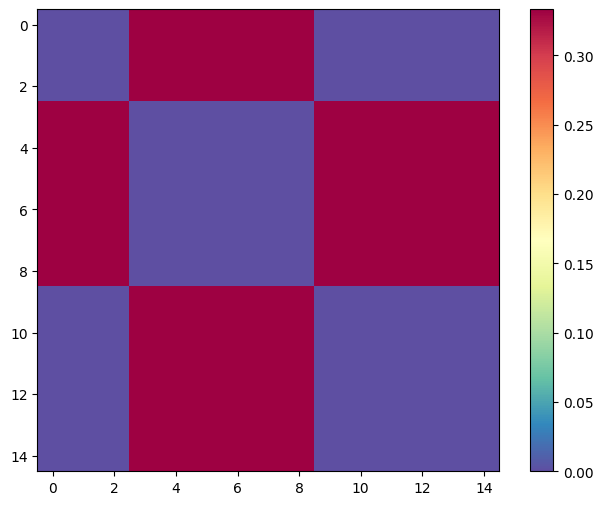

In [212]:
# Groups of five are compounds w.r.t modifier of the target are: target, different modifier, different, same, same
labels_within_group = [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1] # 1 for same relation, 0 for different
same_modifier_rdm = rsa_utils.get_rdm(np.array(labels_within_group).reshape(-1, 1))
rsa_utils.plot_mtx(same_modifier_rdm[:, :15][:15, :], "")

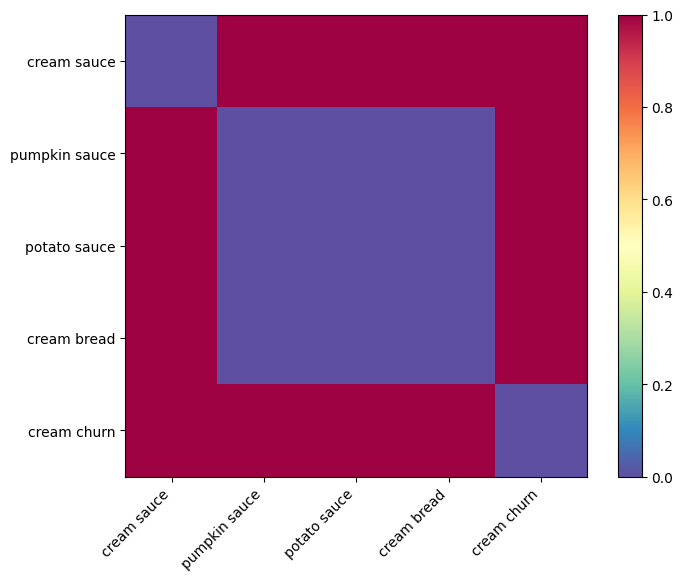

In [213]:
same_modifier_rdm = np.zeros((len(compounds), len(compounds)))

for i, compound_i in enumerate(compounds):
    for j, compound_j in enumerate(compounds):
        same_modifier_rdm[i, j] = compound_i.split()[0] != compound_j.split()[0]
        
same_modifier_rdm = same_modifier_rdm[paraphrase_inds, :][:, paraphrase_inds]

start = 10
sent_inds = np.arange(start * 5, start * 5 + 5)
# rdm_inds = np.arange(0, 15, 3)

fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(same_modifier_rdm[sent_inds, :][:, sent_inds], interpolation='nearest', cmap='Spectral_r')
plt.title('')
plt.colorbar();

plt.xticks(ticks=np.arange(5), labels=['{}'.format(compounds[x], x) for x in sent_inds], rotation=45, ha='right');
plt.yticks(ticks=np.arange(5), labels=['{}'.format(compounds[x], x) for x in sent_inds], rotation=0, ha='right');

In [214]:
group_rdms_to_correlate = [("same_relation_group_rdm", same_relation_group_rdm), ("same_head_rdm", same_head_rdm), ("same_modifier_rdm", same_modifier_rdm)]

In [215]:
load = False

if load:
    relation_results_within_compound_groups_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_experimental_conditions_deepseek_3B.csv')
else:
    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)

        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds_mean_pooled/{}_layer_{}_noun_noun_compounds_mean_pooled.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            rdm = rsa_utils.get_rdm(reps[paraphrase_inds])
            row = {'model': model_name, 'layer': layer}

            for target_rdm_name, target_rdm in group_rdms_to_correlate:
                second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
                row = {**row, **rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already, corr_metric=corr_metric)}
                np.savetxt('E:/NOUN-NOUN-COMPOUNDS-V1/data/test/experimental_{}_3.csv'.format(target_rdm_name), target_rdm)

            rows.append(row)
    
        np.savetxt('E:/NOUN-NOUN-COMPOUNDS-V1/data/test/900_rep_rdm_7.csv', rdm)
    
    relation_results_within_compound_groups_df = pd.DataFrame(rows)
    relation_results_within_compound_groups_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_experimental_conditions_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [00:59<00:00,  2.14s/it]


bert-base-japanese


100%|██████████| 28/28 [00:59<00:00,  2.12s/it]


openai-community/gpt2


100%|██████████| 28/28 [00:58<00:00,  2.10s/it]


microsoft/phi-1


100%|██████████| 28/28 [02:05<00:00,  4.49s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [02:22<00:00,  5.08s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [02:26<00:00,  5.24s/it]


In [216]:
def corr_within_group(rdm_a, rdm_b):
    return corr(data_utils.select_within_compound_groups(rdm_a.reshape(900, 900)), data_utils.select_within_compound_groups(rdm_b.reshape(900, 900)))

def run_correlations(rdm, model_name, layer):
    semantic_equivalence_rdm_corr, semantic_equivalence_rdm_pvalue = rsa_utils.correlate_over_groups(paraphrase_identity_rdm, rdm, corr_metric=corr_metric)
    jaccard_corr, jaccard_pvalue = rsa_utils.correlate_over_groups(jaccard_rdm, rdm, corr_metric=corr_metric)
    monge_elkan_corr, monge_elkan_pvalue = rsa_utils.correlate_over_groups(monge_elkan_rdm, rdm, corr_metric=corr_metric)
    ratcliff_obershelp_corr, ratcliff_obershelp_pvalue = rsa_utils.correlate_over_groups(ratcliff_obershelp_rdm, rdm, corr_metric=corr_metric)
    levenshtein_corr, levenshtein_pvalue = rsa_utils.correlate_over_groups(levenshtein_rdm, rdm, corr_metric=corr_metric)
    fasttext_corr, fasttext_pvalue = rsa_utils.correlate_over_groups(ordered_fasttext_mean_rdm, rdm, corr_metric=corr_metric)

    return {'model': model_name, 'layer': layer, "semantic_equivalence_rdm_corr":  semantic_equivalence_rdm_corr, 
                "semantic_equivalence_rdm_pvalue":  semantic_equivalence_rdm_pvalue, "jaccard_corr": jaccard_corr, "jaccard_pvalue": jaccard_pvalue,
                "monge_elkan_corr": monge_elkan_corr, "monge_elkan_pvalue": monge_elkan_pvalue, "ratcliff_obershelp_corr": ratcliff_obershelp_corr, 
                "ratcliff_obershelp_pvalue": ratcliff_obershelp_pvalue, "levenshtein_corr": levenshtein_corr, "levenshtein_pvalue": levenshtein_pvalue, 
                "fasttext_corr": fasttext_corr, "fasttext_pvalue": fasttext_pvalue}

In [217]:
load = False

if load:
    results_per_word_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_per_word_transformers_deepseek_3B.csv')
    noun_noun_compound_similarity_results = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/noun_noun_compound_similarity_results_deepseek_3B.csv')
else:
    noun_noun_compound_similarity_rows = []
    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue
            
            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
            compound_rdm = rsa_utils.get_rdm(reps.mean(axis=1)[paraphrase_inds])
            head_noun_rdm = rsa_utils.get_rdm(reps[:, 1, :].squeeze()[paraphrase_inds])
            mod_word_rdm = rsa_utils.get_rdm(reps[:, 0, :].squeeze()[paraphrase_inds])
                       


            for rdm_name, rdm in [('compound_mean', compound_rdm), ('head_noun_mean', head_noun_rdm), ('mod_word_mean', mod_word_rdm)]:
                row = {'model': model_name, 'layer': layer, 'representation': rdm_name}

                for target_rdm_name, target_rdm in rdms_to_correlate:
                    row = {**row, **rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=False, corr_metric=corr_metric)}

                rows.append(row)
            

            noun_noun_compound_similarity_rows.append({'model': model_name, 'layer': layer, 'avg_head_mod_dist': np.mean([cosine(reps[i, 1, :].squeeze(), reps[i, 0, :].squeeze()) for i in range(900)]),
                                                       'compound_correlation': corr(head_noun_rdm, mod_word_rdm).correlation})



    results_per_word_df = pd.DataFrame(rows)
    results_per_word_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_per_word_transformers_deepseek_3B.csv')
    noun_noun_compound_similarity_results = pd.DataFrame(noun_noun_compound_similarity_rows)
    noun_noun_compound_similarity_results.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/noun_noun_compound_similarity_results_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [05:55<00:00, 12.69s/it]


bert-base-japanese


100%|██████████| 28/28 [06:01<00:00, 12.92s/it]


openai-community/gpt2


100%|██████████| 28/28 [06:03<00:00, 13.00s/it]


microsoft/phi-1


100%|██████████| 28/28 [12:13<00:00, 26.21s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [13:57<00:00, 29.90s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [14:43<00:00, 31.57s/it]


In [218]:
def get_results(rdm, model_name, layer):
    same_relation_within_groups_corr, same_relation_within_groups_pvalue = rsa_utils.correlate_over_groups(rdm, rsa_utils.get_lower_triangle(same_relation_group_rdm), second_rdm_group_level_already=True, corr_metric=corr_metric)
    same_head_within_groups_corr, same_head_within_groups_pvalue = rsa_utils.correlate_over_groups(rdm, rsa_utils.get_lower_triangle(same_head_rdm), second_rdm_group_level_already=True, corr_metric=corr_metric)
    same_modifier_within_groups_corr, same_modifier_within_groups_pvalue = rsa_utils.correlate_over_groups(rdm, rsa_utils.get_lower_triangle(same_modifier_rdm), second_rdm_group_level_already=True, corr_metric=corr_metric)

    return {'model': model_name, 'layer': layer, 
             "same_relation_within_groups_corr": same_relation_within_groups_corr, "same_relation_within_groups_pvalue": same_relation_within_groups_pvalue,
             "same_head_within_groups_corr": same_head_within_groups_corr, "same_head_within_groups_pvalue": same_head_within_groups_pvalue,
             "same_modifier_within_groups_corr": same_modifier_within_groups_corr, "same_modifier_within_groups_pvalue": same_modifier_within_groups_pvalue}

In [219]:
row = {'model': 'random', 'layer': 'none', 'representation': 'random'}

random_rdm = rsa_utils.get_rdm(np.random.randn(900, 1000)[paraphrase_inds])
row = {**row, **rsa_utils.correlate_over_groups_and_get_row_values(random_rdm, group_rdms_to_correlate[0][-1], 'same_relation_group_rdm', second_rdm_group_level_already=True)}


In [220]:
load = False

if load:
    relation_results_within_compound_groups_per_word_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_3B.csv')
else:
    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)

        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))


            compound_rdm = rsa_utils.get_rdm(reps.mean(axis=1)[paraphrase_inds])
            head_noun_rdm = rsa_utils.get_rdm(reps[:, 1, :].squeeze()[paraphrase_inds])
            mod_word_rdm = rsa_utils.get_rdm(reps[:, 0, :].squeeze()[paraphrase_inds])
            for rdm_name, rdm in [('compound_mean', compound_rdm), ('head_noun_mean', head_noun_rdm), ('mod_word_mean', mod_word_rdm)]:
                row = {'model': model_name, 'layer': layer, 'representation': rdm_name}

                


                for target_rdm_name, target_rdm in group_rdms_to_correlate:
                    second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
                    row = {**row, **rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already)}

                rows.append(row)


    relation_results_within_compound_groups_per_word_df = pd.DataFrame(rows)
    relation_results_within_compound_groups_per_word_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [02:28<00:00,  5.31s/it]


bert-base-japanese


100%|██████████| 28/28 [02:35<00:00,  5.56s/it]


openai-community/gpt2


100%|██████████| 28/28 [02:32<00:00,  5.44s/it]


microsoft/phi-1


100%|██████████| 28/28 [05:12<00:00, 11.15s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [05:58<00:00, 12.82s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [06:21<00:00, 13.63s/it]


## 1A

In [221]:
all_reps = np.random.randn(900, 768)
random_rdm = rsa_utils.get_rdm(all_reps)

# rsa_utils.plot_mtx(random_rdm, 'Random RDM')

In [222]:
model_names = [ "roberta-base", "bert-base-japanese", "openai-community/gpt2", "microsoft/phi-1", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", "meta-llama/Llama-3.2-3B"]

In [223]:
load = False

if load:
    relation_results_within_compound_groups_per_word_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_3B.csv')
    
    with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/compound_correlation_dict12.pkl', 'rb') as f:
        compound_correlation_dict = pickle.load(f)
    
else:
    rows = []
    i = 0
    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)
    
    compound_correlation_dict = {}
    
    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
            compound_rdm = rsa_utils.get_rdm(reps.mean(axis=1)[paraphrase_inds])
            head_noun_rdm = rsa_utils.get_rdm(reps[:, 1, :].squeeze()[paraphrase_inds])
            mod_word_rdm = rsa_utils.get_rdm(reps[:, 0, :].squeeze()[paraphrase_inds])




            for rdm_name, rdm in [('compound_mean', compound_rdm), ('head_noun_mean', head_noun_rdm), ('mod_word_mean', mod_word_rdm)]:

                row = {'model': model_name, 'layer': layer, 'representation': rdm_name}

                for target_rdm_name, target_rdm in group_rdms_to_correlate:
                    second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
                    res, corrs = rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already,
                                                                                          keep_corrs=True)
                    row = {**row, **res}
                    
                    if target_rdm_name == 'same_relation_group_rdm' and 'compound' in rdm_name:
                        compound_correlation_dict['{}_{}'.format(model_name, layer)] = corrs 
                    
                    rows.append(row)

    with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/compound_correlation_dict12.pkl', 'wb') as f:
        pickle.dump(compound_correlation_dict, f, pickle.HIGHEST_PROTOCOL)
        
    relation_results_within_compound_groups_per_word_df = pd.DataFrame(rows)
    relation_results_within_compound_groups_per_word_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [02:33<00:00,  5.47s/it]


bert-base-japanese


100%|██████████| 28/28 [02:32<00:00,  5.43s/it]


openai-community/gpt2


100%|██████████| 28/28 [02:26<00:00,  5.24s/it]


microsoft/phi-1


100%|██████████| 28/28 [05:23<00:00, 11.55s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [06:03<00:00, 12.97s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [06:20<00:00, 13.61s/it]


In [224]:
load = True

if not load:
    nrand = 100
    random_rows = []

    for n in tqdm.tqdm(range(nrand)):
        all_reps = np.random.randn(900, 768)
        rdm = rsa_utils.get_rdm(all_reps)

        random_row = {'n': n}
        for target_rdm_name, target_rdm in group_rdms_to_correlate:
            second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
            random_row = {**random_row, **rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already)}

        random_rows.append(random_row)

    random_df = pd.DataFrame(random_rows)
    random_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/random_df.csv')
else:
    random_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/random_df.csv')

same_relation_group_rdm_corr_within_compound_sentences


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\3013774736.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\3013774736.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\3013774736.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


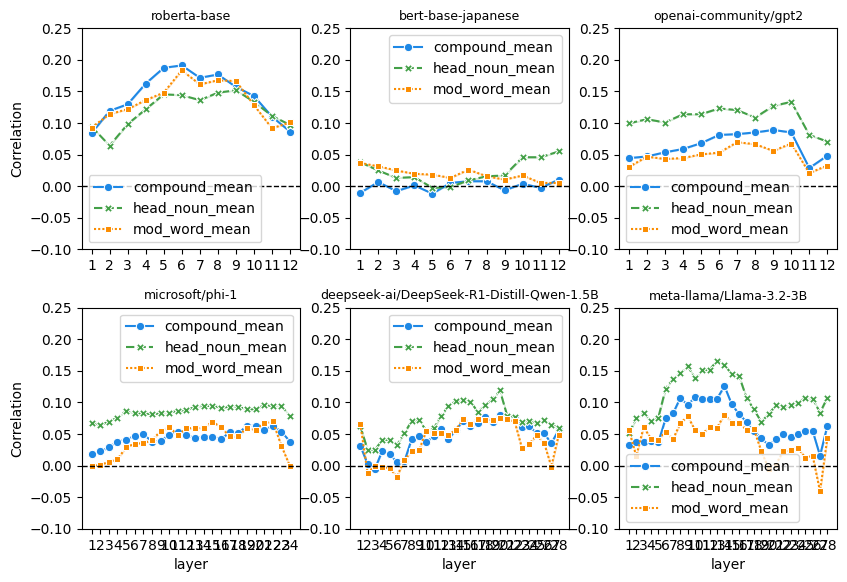

In [225]:
# Experiment 1a

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "compound_mean": "#1E88E5",  # Blue
    "final_word": "#1E88E5",     # Blue
    "final_mod": "#FB8C00",      # Orange
    "mod_word_mean": "#FB8C00",  # Orange
    "final_head": "#43A047",     # Green
    "head_noun_mean": "#43A047"  # Green
}


for y, ylim in zip(['same_relation_group_rdm_corr_within_compound_sentences'], [(-0.1, 0.25)]):
    #fig_shape = (2, 3)
    fig_shape = (2, 3)
    fig_df = relation_results_within_compound_groups_per_word_df
    fig_df = sort_df_by_model_order(fig_df)
    
    print(y)
    single_fig_size = 4
    fig = plt.figure(figsize=(fig_shape[1] * 3.25, fig_shape[0] * 3.25, ))

    grid_height = fig_shape[0] * single_fig_size
    grid_width = fig_shape[1] * single_fig_size
    grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)

    for (i, model_df), (fig_y, fig_x) in zip(fig_df.groupby('model_order'), product(range(fig_shape[0]), range(fig_shape[1]))):
        #model_df = sort_df_by_model_order(model_df)
        # print(model, fig_coords)
        model = model_df.iloc[0].model
        line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
        g = sns.lineplot(data=model_df, hue='representation', y=y, x='layer', style='representation', markers=True, palette = representation_colors, ax=line_plot_ax);
        line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)
        g.set(ylim=ylim);

        if fig_x == 0:
            g.set_ylabel('Correlation');
        else:
            g.set_ylabel('');
            
        if fig_y == 0:
            g.set_xlabel('');
        g.legend(loc='best');
        # if fig_x == 0 and fig_y == 0:
        #     g.legend(loc='best', bbox_to_anchor=(1.5, -2, 0.5, 0.5), ncol=1);
        # else:
        #     g.legend().remove();
            
        g.axhline(0, color='black', linestyle='--', linewidth=1)

        g.set_title(model, fontsize = 9);
    plt.tight_layout()
    fig.show()
    
plt.tight_layout()




plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_deepseek_original_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_deepseek_original_3B.eps', format='eps', bbox_inches='tight')

In [226]:
load = False

if load:
    relation_results_within_compound_groups_per_word_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_final_word_tokens_avg_3B.csv')
    
    with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/compound_correlation_dict_final_word1.pkl', 'rb') as f:
        compound_correlation_dict = pickle.load(f)
    
else:
    rows = []
    i = 0
    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)
    representations = ["final_word", "final_head", "final_mod"]
    compound_correlation_dict = {}
    
    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            
            if model_name in ['roberta-base', 'bert-base-japanese']:

                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                compound_rdm = rsa_utils.get_rdm(reps.mean(axis=1)[paraphrase_inds])
                head_noun_rdm = rsa_utils.get_rdm(reps[:, 1, :].squeeze()[paraphrase_inds])
                mod_word_rdm = rsa_utils.get_rdm(reps[:, 0, :].squeeze()[paraphrase_inds])

                for rdm_name, rdm in [('compound_mean', compound_rdm), ('head_noun_mean', head_noun_rdm), ('mod_word_mean', mod_word_rdm)]:

                    row = {'model': model_name, 'layer': layer, 'representation': rdm_name}

                    for target_rdm_name, target_rdm in group_rdms_to_correlate:
                        second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
                        res, corrs = rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already,
                                                                                          keep_corrs=True)
                        row = {**row, **res}
                    
                        if target_rdm_name == 'same_relation_group_rdm' and 'compound' in rdm_name:
                            compound_correlation_dict['{}_{}'.format(model_name, layer)] = corrs 
                    
                        rows.append(row)




            elif model_name in ['openai-community/gpt2', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'microsoft/phi-1' ,'meta-llama/Llama-3.2-3B']:
                
            
                for rep in representations:
                
                
                
                    if rep == 'final_word':
                    
                        #reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_but_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_that_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                        reps = np.mean([reps_and, reps_but, reps_that], axis=0)


                    elif rep == "final_head":
                    
                        reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_head/{}_layer_{}_final_head_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        
                    elif rep == "final_mod":
                    
                        reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_mod/{}_layer_{}_final_mod_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                    
                      
                    rdm = rsa_utils.get_rdm(reps[paraphrase_inds])
                    row = {'model': model_name, 'layer': layer, 'representation': rep}

                    for target_rdm_name, target_rdm in group_rdms_to_correlate:
                        second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'

                        res, corrs = rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already,
                                                                                          corr_metric=corr_metric, keep_corrs=True)

                        row = {**row, **res}
                        #row = {**row, **rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already, corr_metric=corr_metric)}
                        
                        if target_rdm_name == 'same_relation_group_rdm' and rep == 'final_word':
                            compound_correlation_dict['{}_{}'.format(model_name, layer)] = corrs 
                        
                        rows.append(row)
                
                               
                

    with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/compound_correlation_dict_final_word1.pkl', 'wb') as f:
        pickle.dump(compound_correlation_dict, f, pickle.HIGHEST_PROTOCOL)
        
    relation_results_within_compound_groups_per_word_df = pd.DataFrame(rows)
    relation_results_within_compound_groups_per_word_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_final_word_tokens_avg_3B.csv')

roberta-base


100%|██████████| 28/28 [02:39<00:00,  5.71s/it]


bert-base-japanese


100%|██████████| 28/28 [02:32<00:00,  5.45s/it]


openai-community/gpt2


100%|██████████| 28/28 [02:38<00:00,  5.67s/it]


microsoft/phi-1


100%|██████████| 28/28 [05:26<00:00, 11.67s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [06:03<00:00, 12.99s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [06:14<00:00, 13.37s/it]


same_relation_group_rdm_corr_within_compound_sentences


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\1704633370.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\1704633370.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\1704633370.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


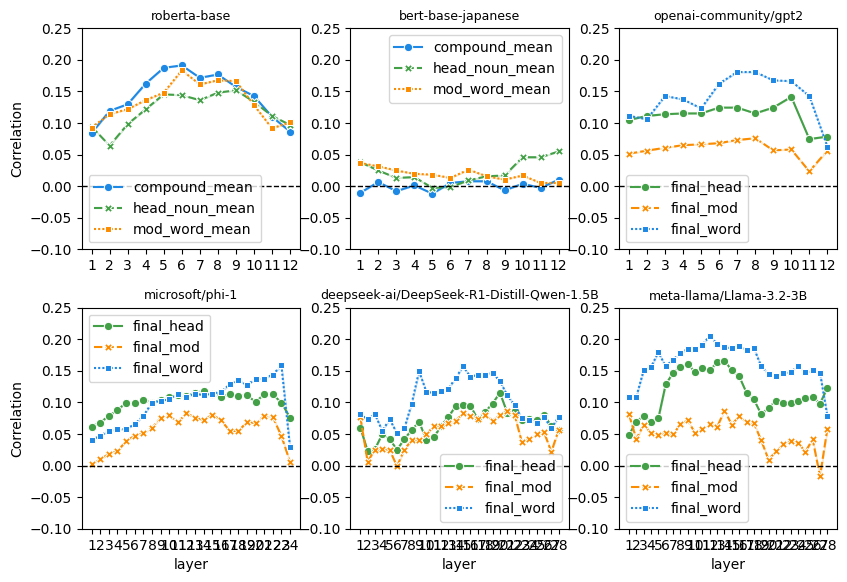

In [227]:
# Experiment 1a

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "compound_mean": "#1E88E5",  # Blue
    "final_word": "#1E88E5",     # Blue
    "final_mod": "#FB8C00",      # Orange
    "mod_word_mean": "#FB8C00",  # Orange
    "final_head": "#43A047",     # Green
    "head_noun_mean": "#43A047"  # Green
}


for y, ylim in zip(['same_relation_group_rdm_corr_within_compound_sentences'], [(-0.1, 0.25)]):
    #fig_shape = (2, 3)
    fig_shape = (2, 3)
    fig_df = relation_results_within_compound_groups_per_word_df
    fig_df = sort_df_by_model_order(fig_df)
    
    print(y)
    single_fig_size = 4
    fig = plt.figure(figsize=(fig_shape[1] * 3.25, fig_shape[0] * 3.25, ))

    grid_height = fig_shape[0] * single_fig_size
    grid_width = fig_shape[1] * single_fig_size
    grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)

    for (i, model_df), (fig_y, fig_x) in zip(fig_df.groupby('model_order'), product(range(fig_shape[0]), range(fig_shape[1]))):
        #model_df = sort_df_by_model_order(model_df)
        # print(model, fig_coords)
        model = model_df.iloc[0].model
        line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
        g = sns.lineplot(data=model_df, hue='representation', y=y, x='layer', style='representation', markers=True, palette = representation_colors, ax=line_plot_ax);
        line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)
        g.set(ylim=ylim);

        if fig_x == 0:
            g.set_ylabel('Correlation');
        else:
            g.set_ylabel('');
            
        if fig_y == 0:
            g.set_xlabel('');
        g.legend(loc='best');
        # if fig_x == 0 and fig_y == 0:
        #     g.legend(loc='best', bbox_to_anchor=(1.5, -2, 0.5, 0.5), ncol=1);
        # else:
        #     g.legend().remove();
            
        g.axhline(0, color='black', linestyle='--', linewidth=1)

        g.set_title(model, fontsize = 9);
    plt.tight_layout()
    fig.show()
    
plt.tight_layout()




plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_deepseek_3B.eps', format='eps', bbox_inches='tight')

## 1B

In [228]:
load = False

if load:
    experiment_1b_results_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/experiment_1b_results_deepseek_3B.csv')    
    
    with open('experiment_1b_compound_correlation_dict11.pkl', 'rb') as f:
        experiment_1b_compound_correlation_dict = pickle.load(f)
else:
    rows = []
    
    experiment_1b_compound_correlation_dict = {}

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue
            
            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis/{}_layer_{}_compositional_analysis.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            reps = np.mean(np.dstack([reps[np.where(np.arange(reps.shape[0]) % 2 == 0)], reps[np.where(np.arange(reps.shape[0]) % 2 == 1)]]), axis=-1)                                             
            
            all_reps = np.zeros((900, reps.shape[-1]))

            for i in range(900):
                all_reps[i, :] = reps[i // 3, :]
                
            rdm = rsa_utils.get_rdm(all_reps)
            
            row = {'model': model_name, 'layer': layer, 'representation': 'not_processed_together'}

            for target_rdm_name, target_rdm in [group_rdms_to_correlate[0]]:
                second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
                
                res, corrs = rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already, keep_corrs=True)
                row = {**row, **res}
                
                if target_rdm_name == 'same_relation_group_rdm':
                    experiment_1b_compound_correlation_dict['{}_{}'.format(model_name, layer)] = corrs 
            rows.append(row)
            
    with open('./experiment_1b_compound_correlation_dict11.pkl', 'wb') as f:
        pickle.dump(experiment_1b_compound_correlation_dict, f, pickle.HIGHEST_PROTOCOL)
        
    experiment_1b_results_df = pd.DataFrame(rows)
    experiment_1b_results_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/experiment_1b_results_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [00:10<00:00,  2.62it/s]


bert-base-japanese


100%|██████████| 28/28 [00:10<00:00,  2.66it/s]


openai-community/gpt2


100%|██████████| 28/28 [00:10<00:00,  2.68it/s]


microsoft/phi-1


100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [00:27<00:00,  1.02it/s]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [00:35<00:00,  1.25s/it]


In [229]:
def format_p_val(p):

    if hasattr(p, 'pvalue'):
        p = p.pvalue
    p = round(p, 2)
    
    if p == -1:
        p = '-'
    elif p < 0.0001:
        p = 'p<0.0001'  
    elif p < 0.001:
        p = 'p<0.001'
    elif p < 0.01:
        p = 'p<0.01'
    elif p < 0.05:
        p = 'p<0.05'
    else:
        p = 'p={}'.format(p)
    
    return p 

def bonferonni_correction(df):
    # p == -1 for distilroberta layers 7-12 (i.e. non-existent layers)
    fdr_method = 'indep' # 'indep' or 'negcorr
    num_tests = paired_t_test_df[paired_t_test_df.p != -1].shape[0]
    
    df.loc[df.p != -1, 'corrected_p'] =  paired_t_test_df[paired_t_test_df.p != -1].p * num_tests
    df.loc[df.p == -1, 'corrected_p'] = -1

    df['formatted_corrected_p']  = list(map(format_p_val, df.corrected_p))
    
    return df

def fdr_correction(df):
    # p == -1 for distilroberta layers 7-12 (i.e. non-existent layers)
    fdr_error_rate = 0.05 # default = 0.05
    fdr_method = 'negcorr' # 'indep' or 'negcorr
    df.loc[df.p > -1, 'corrected_p'] = fdrcorrection(df[df.p > -1].p.tolist(), method=fdr_method, alpha=fdr_error_rate)[-1]
    df.loc[df.p == -1, 'corrected_p'] = -1
    df['formatted_corrected_p']  = list(map(format_p_val, df.corrected_p))
    
    return df

In [230]:
rows = []

for model in model_names:
    for layer in list(range(1, 29)):
        row = {'model': model, 'layer': layer}
        
        if 'bert' in model and layer > 12:
            row['p'] = -1
        elif 'xlnet' in model and layer > 12:
            row['p'] = -1
        elif 'xlm' in model and layer > 12:
            row['p'] = -1
        elif 'gpt' in model and layer > 12:
            row['p'] = -1
        elif 'distil' in model and layer > 6:
            row['p'] = -1
        elif 'phi' in model and layer > 24:
            row['p'] = -1
        else:
            
        
            group_correlations_processed_together = compound_correlation_dict['{}_{}'.format(model, layer)]
            group_correlations_processed_apart = experiment_1b_compound_correlation_dict['{}_{}'.format(model, layer)]
            row['p'] =  ttest_rel(group_correlations_processed_together, group_correlations_processed_apart, alternative='greater').pvalue
            
        rows.append(row)
        
paired_t_test_df = pd.DataFrame(rows)

paired_t_test_df = fdr_correction(paired_t_test_df)

C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\2653013758.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


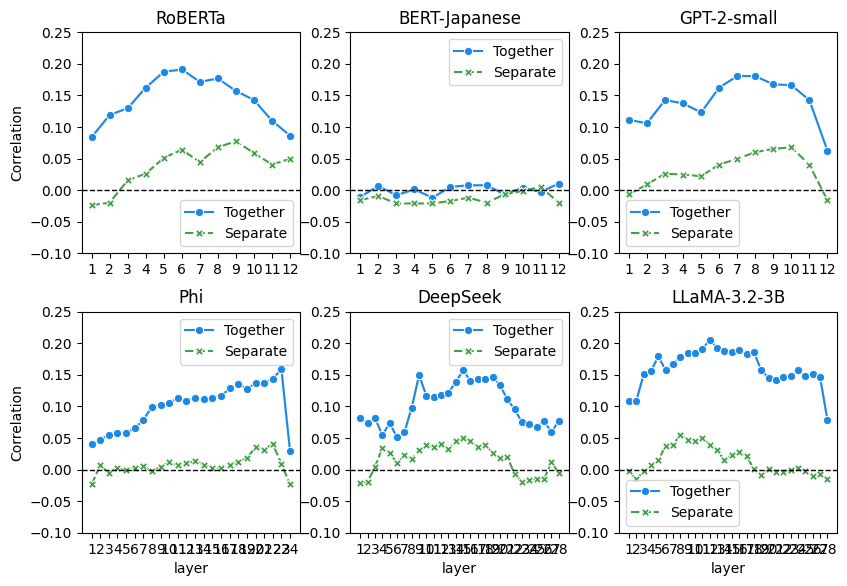

In [231]:
# Experiment 1b

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):
representation_colors = {
    "Together": "#1E88E5",  # Blue
    "Separate": "#43A047"  # Green
}

for y, ylim in zip(['same_relation_group_rdm_corr_within_compound_sentences'], [(-0.1, 0.25)]):
    #fig_shape = (2, 3)
    fig_shape = (2, 3)

    #rows = relation_results_within_compound_groups_per_word_df[relation_results_within_compound_groups_per_word_df.representation == 'compound_mean'].copy()
    rows = relation_results_within_compound_groups_per_word_df[relation_results_within_compound_groups_per_word_df.representation.isin(['compound_mean', 'final_word'])].copy()
    
    rows['Processing condition'] = 'Together'
    experiment_1b_results_df['Processing condition'] = 'Separate'


    fig_df = pd.concat([rows, experiment_1b_results_df])   
    fig_df = sort_df_by_model_order(fig_df)
   


    
    single_fig_size = 4
    fig = plt.figure(figsize=(fig_shape[1] * 3.25, fig_shape[0] * 3.25, ))

    grid_height = fig_shape[0] * single_fig_size
    grid_width = fig_shape[1] * single_fig_size
    grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)
    

    for (i, model_df), (fig_y, fig_x) in zip(fig_df.groupby('model_order'), product(range(fig_shape[0]), range(fig_shape[1]))):
        model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
        model = model_df.iloc[0].model
        model_name = model_df.iloc[0].model_name
    
        line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
        g = sns.lineplot(data=model_df, hue='Processing condition', y=y, x='layer', style='Processing condition', markers=True, palette= representation_colors, ax=line_plot_ax);
        line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)
        g.set(ylim=ylim);

        if fig_x == 0:
            g.set_ylabel('Correlation');
        else:
            g.set_ylabel('');
            
        if fig_y == 0:
            g.set_xlabel('');

        # if fig_x == 0 and fig_y == 0:
        #     g.legend(loc='best', bbox_to_anchor=(1.5, -2, 0.5, 0.5), ncol=1);
        # else:
        #     g.legend().remove();
        g.legend(loc='best');

        
        g.axhline(0, color='black', linestyle='--', linewidth=1)
        
        g.set_title(model_name);
        
        # for layer in model_df.layer.unique():
        #     pval = paired_t_test_df[(paired_t_test_df.model == model) & (paired_t_test_df.layer == layer)]['corrected_p'].iloc[0]
        #     x_offset =  0.075 if 'distil' in model else 0.2
        #     y_offset = 0.1 - 0.035

        #     if pval <= 0.05:
        #         y_val = model_df[(model_df.layer==layer)]['same_relation_group_rdm_corr_within_compound_sentences'].min()
        #         plt.text(layer - x_offset, 0 - y_offset, '*', weight='bold', size='x-large', color='black')
        
    fig.show()
    
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_1b_deepseek_original_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_1b_deepseek_original_3B.eps', format='eps', bbox_inches='tight')

In [232]:
load = False

if load:
    experiment_1b_results_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/experiment_1b_results_deepseek_final_word_avg_3B.csv')    
    
    with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/experiment_1b_compound_correlation_dict_decode_avg1.pkl', 'rb') as f:
        experiment_1b_compound_correlation_dict = pickle.load(f)
else:
    rows = []
    
    experiment_1b_compound_correlation_dict = {}

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue
            
            
            if model_name in ['openai-community/gpt2', 'microsoft/phi-1' , 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'meta-llama/Llama-3.2-3B']:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_and.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                # reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_and.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                # reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_but.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                # reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_that.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                # reps = np.mean([reps_and, reps_but, reps_that], axis=0)

                




            else:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis/{}_layer_{}_compositional_analysis.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
            reps = np.mean(np.dstack([reps[np.where(np.arange(reps.shape[0]) % 2 == 0)], reps[np.where(np.arange(reps.shape[0]) % 2 == 1)]]), axis=-1)                                             
            
            all_reps = np.zeros((900, reps.shape[-1]))

            for i in range(900):
                all_reps[i, :] = reps[i // 3, :]
                
            rdm = rsa_utils.get_rdm(all_reps)
            
            
            row = {'model': model_name, 'layer': layer, 'representation': 'not_processed_together'}

            for target_rdm_name, target_rdm in [group_rdms_to_correlate[0]]:

                second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
                
               
                res, corrs = rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already, keep_corrs=True)
                row = {**row, **res}
                
                if target_rdm_name == 'same_relation_group_rdm':
                    experiment_1b_compound_correlation_dict['{}_{}'.format(model_name, layer)] = corrs 
            rows.append(row)
            
    with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/experiment_1b_compound_correlation_dict_decode_avg1.pkl', 'wb') as f:
        pickle.dump(experiment_1b_compound_correlation_dict, f, pickle.HIGHEST_PROTOCOL)
        
    experiment_1b_results_df = pd.DataFrame(rows)
    experiment_1b_results_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/experiment_1b_results_deepseek_final_word_avg_3B.csv')

roberta-base


100%|██████████| 28/28 [00:10<00:00,  2.69it/s]


bert-base-japanese


100%|██████████| 28/28 [00:10<00:00,  2.70it/s]


openai-community/gpt2


100%|██████████| 28/28 [00:10<00:00,  2.64it/s]


microsoft/phi-1


100%|██████████| 28/28 [00:26<00:00,  1.05it/s]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [00:27<00:00,  1.01it/s]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [00:36<00:00,  1.29s/it]


In [233]:
rows = []

for model in model_names:
    for layer in list(range(1, 29)):
        row = {'model': model, 'layer': layer}
        
        if 'bert' in model and layer > 12:
            row['p'] = -1
        elif 'xlnet' in model and layer > 12:
            row['p'] = -1
        elif 'xlm' in model and layer > 12:
            row['p'] = -1
        elif 'gpt' in model and layer > 12:
            row['p'] = -1
        elif 'distil' in model and layer > 6:
            row['p'] = -1
        elif 'phi' in model and layer > 24:
            row['p'] = -1
        else:
            
        
            group_correlations_processed_together = compound_correlation_dict['{}_{}'.format(model, layer)]
            group_correlations_processed_apart = experiment_1b_compound_correlation_dict['{}_{}'.format(model, layer)]
            row['p'] =  ttest_rel(group_correlations_processed_together, group_correlations_processed_apart, alternative='greater').pvalue
            
        rows.append(row)
        
paired_t_test_df = pd.DataFrame(rows)

paired_t_test_df = fdr_correction(paired_t_test_df)

C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\2673371644.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


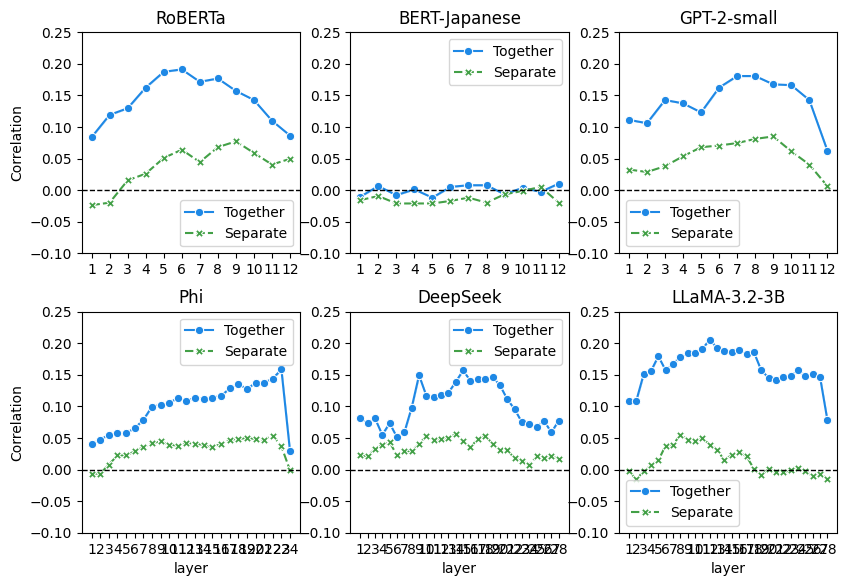

In [234]:
# Experiment 1b

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):
representation_colors = {
    "Together": "#1E88E5",  # Blue
    "Separate": "#43A047"  # Green
}

for y, ylim in zip(['same_relation_group_rdm_corr_within_compound_sentences'], [(-0.1, 0.25)]):
    #fig_shape = (2, 3)
    fig_shape = (2, 3)

    #rows = relation_results_within_compound_groups_per_word_df[relation_results_within_compound_groups_per_word_df.representation == 'compound_mean'].copy()
    rows = relation_results_within_compound_groups_per_word_df[relation_results_within_compound_groups_per_word_df.representation.isin(['compound_mean', 'final_word'])].copy()
    
    rows['Processing condition'] = 'Together'
    experiment_1b_results_df['Processing condition'] = 'Separate'


    fig_df = pd.concat([rows, experiment_1b_results_df])   
    fig_df = sort_df_by_model_order(fig_df)
   


    
    single_fig_size = 4
    fig = plt.figure(figsize=(fig_shape[1] * 3.25, fig_shape[0] * 3.25, ))

    grid_height = fig_shape[0] * single_fig_size
    grid_width = fig_shape[1] * single_fig_size
    grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)
    

    for (i, model_df), (fig_y, fig_x) in zip(fig_df.groupby('model_order'), product(range(fig_shape[0]), range(fig_shape[1]))):
        model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
        model = model_df.iloc[0].model
        model_name = model_df.iloc[0].model_name
    
        line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
        g = sns.lineplot(data=model_df, hue='Processing condition', y=y, x='layer', style='Processing condition', markers=True, palette= representation_colors, ax=line_plot_ax);
        line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)
        g.set(ylim=ylim);

        if fig_x == 0:
            g.set_ylabel('Correlation');
        else:
            g.set_ylabel('');
            
        if fig_y == 0:
            g.set_xlabel('');

        # if fig_x == 0 and fig_y == 0:
        #     g.legend(loc='best', bbox_to_anchor=(1.5, -2, 0.5, 0.5), ncol=1);
        # else:
        #     g.legend().remove();
        g.legend(loc='best');

        
        g.axhline(0, color='black', linestyle='--', linewidth=1)
        
        g.set_title(model_name);
        
        # for layer in model_df.layer.unique():
        #     pval = paired_t_test_df[(paired_t_test_df.model == model) & (paired_t_test_df.layer == layer)]['corrected_p'].iloc[0]
        #     x_offset =  0.075 if 'distil' in model else 0.2
        #     y_offset = 0.1 - 0.035

        #     if pval <= 0.05:
        #         y_val = model_df[(model_df.layer==layer)]['same_relation_group_rdm_corr_within_compound_sentences'].min()
        #         plt.text(layer - x_offset, 0 - y_offset, '*', weight='bold', size='x-large', color='black')
        
    fig.show()
    
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_1b_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/coarse_grained_rsa_results_1b_deepseek_3B.eps', format='eps', bbox_inches='tight')

## FINEGRAINED

In [235]:
df = pd.read_excel('E:/NOUN-NOUN-COMPOUNDS-V1/data/noun_noun_compounds/nn_tax_data.xlsx', skiprows=9)

relation_vectors = []
compounds = []
glosses = []
original_inds = []
finegrained_sentences = []

relation_names = ['{} {} {}'.format(x[0], x[1:-1], x[-1]) for x in df['relation name'][:18].tolist()]
relation_names

for x in df.groupby('itemnr'):
    relation_vectors.append((x[1]['count vector'].tolist()))
    compounds.append('{} {}'.format(x[1]['modifier'].tolist()[0], x[1]['headnoun'].tolist()[0]))
    glosses.append(x[1]['gloss'].tolist()[0])
    original_inds.append(x[1]['Orig nr'].tolist()[0])
    
relation_vectors = np.array(relation_vectors)
compounds = np.array(compounds)
glosses = np.array(glosses)
original_inds = np.array(original_inds)

ind_dict = {}

for gloss_i, gloss in enumerate(glosses):
    for i, sentence in enumerate(sentences):
        if gloss.strip() in sentence:
            ind_dict[gloss_i] = i
            break

use_gloss_inds = False

original_inds = np.array(list(ind_dict.values()))

if not use_gloss_inds:
    original_inds = original_inds % 300

finegrained_nn_sentences = sentences[original_inds]

In [236]:
get_relation_names = lambda i: ', '.join([relation_names[x] for x in np.argsort(relation_vectors[i])[::-1][:3]])
top_three_relations_per_compound = np.array(['{} ({})'.format(x, get_relation_names(i)) for i, x in enumerate(compounds)])
get_relation_names = lambda i: ', '.join([relation_names[x] for x in np.argsort(relation_vectors[i])[::-1][1:4]])
top_three_other_relations_per_compound = np.array(['{}'.format(get_relation_names(i)) for i, x in enumerate(compounds)])

# top_three_relations_per_compound[:10]

In [237]:
rows = []

for i, compound_i in enumerate(compounds):
    for j, compound_j in enumerate(compounds):
        if i < j:
            top_relation_i = relation_names[np.argmax(relation_vectors[i])]
            top_relation_j = relation_names[np.argmax(relation_vectors[j])]
            shares_top_relation = top_relation_i == top_relation_j
            
            relation_vector_distance = cosine(relation_vectors[i], relation_vectors[j])

            rows.append({'i': i, 'compound_i': compound_i, 'j': j, 'compound_j': compound_j, 'top_relation_i': top_relation_i, 'top_relation_j': top_relation_j,
                         'shares_top_relation': shares_top_relation, 'relation_vector_cosine_distance': relation_vector_distance, 'other_top_3_relations_i': top_three_other_relations_per_compound[i], 
                         'other_top_3_relations_j': top_three_other_relations_per_compound[j]})
            
compound_result_df = pd.DataFrame(rows)

# res = sns.distplot(compound_result_df[compound_result_df.shares_top_relation==True].relation_vector_cosine_distance)
# res = sns.distplot(compound_result_df[compound_result_df.shares_top_relation==False].relation_vector_cosine_distance)
# res.legend(['Pair shares top relation', 'Top relation different'])
# res.set_ylabel('Density')
# res.set_xlabel('Cosine distance between relation vectors')
# res.set_title('Cosine distance between all pairs of 60 compounds')

In [238]:
top_relations_to_print = range(1, 19)

reordered_relation_vectors_dict = {}
rdms_per_num_top_relations = {}
reordered_orig_indices_per_top_relations = {}
reordered_compound_indices = {}
filtered_reordered_orig_indices_per_top_relations = {}
conditions = ['_consider_magnitude', '_maximally_dissimilar']

for condition in conditions:
    for num_top_relations in range(1, 19):
        top_relations = relation_vectors.argsort(axis=1)[:, ::-1][:, :num_top_relations]
        new_relation_vectors = np.zeros_like(relation_vectors)

        for i, inds in enumerate(top_relations):
            for ind in inds:
                if condition == '_consider_magnitude':
                    new_relation_vectors[i, ind] = relation_vectors[i, ind]
                else:
                    new_relation_vectors[i, ind] = 1

        relation_vector_rdm = rsa_utils.get_rdm(new_relation_vectors, distance_metric='cosine')

        # Reorder
        least_dist_ind = np.argsort(relation_vector_rdm.sum(axis=0))[0]
        distance_from_least_dist = np.argsort([x[least_dist_ind] for x in relation_vector_rdm])
#         distance_from_least_dist = reordered_compound_indices['18_consider_magnitude']
        reordered_relation_vector_rdm = relation_vector_rdm[distance_from_least_dist, :][:, distance_from_least_dist]
        reordered_orig_indices = original_inds[distance_from_least_dist]
        filtered_reordered_orig_indices = original_inds[distance_from_least_dist]

        rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] = reordered_relation_vector_rdm
        reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] = reordered_orig_indices
        filtered_reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] = reordered_orig_indices
        reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)] = relation_vectors[distance_from_least_dist]
        reordered_compound_indices['{}{}'.format(num_top_relations, condition)] = distance_from_least_dist
        
#         # Plot
#         if num_top_relations in top_relations_to_print and not (condition=='_maximally_dissimilar' and num_top_relations==18):
#             fig, ax = plt.subplots(figsize=(5, 4))
#             g = sns.heatmap(reordered_relation_vector_rdm, cmap="Spectral_r", ax=ax)
# #             res = g.set_yticklabels(compounds[distance_from_least_dist], rotation=0)
# #             res = g.set_xticklabels(compounds[distance_from_least_dist], rotation=75)
#             g.set(xticklabels=[])
#             g.set(yticklabels=[])
#             extra_parentheses = '(Considering whether relation was mentioned at least once)' if condition == '_maximally_dissimilar' else ''
# #             ax.set_title('Relation Vector RDM (Considering top {} relation{}) {}'.format(num_top_relations, "" if num_top_relations == 1 else "s",  extra_parentheses))
#             ax.set_title('Relation Vector RDM (Considering top {} relation{}) {}'.format(num_top_relations, "" if num_top_relations == 1 else "s",  extra_parentheses), fontsize=40)
            
#         if (num_top_relations == 18 or num_top_relations == 1) and condition=='_consider_magnitude':
#             print('True')
#             ax.set_title('')
#             fig_name = '/Volumes/Expansion/noun-compound-transformers-main/noun-compound-transformers/figures/thematic_relation_ground_truth_rdm_top_{}_relations'.format(num_top_relations)
#             plt.axis('off')
#             plt.savefig('{}.png'.format(fig_name), dpi=300)
#             plt.savefig('{}.eps'.format(fig_name), format='eps')
# plt.show()

In [239]:
top_relations_to_print = range(1, 19)

condition = '_consider_magnitude'

for num_top_relations in [1, 18]:
    top_relations = relation_vectors.argsort(axis=1)[:, ::-1][:, :num_top_relations]
    new_relation_vectors = np.zeros_like(relation_vectors)

    for i, inds in enumerate(top_relations):
        for ind in inds:
            if condition == '_consider_magnitude':
                new_relation_vectors[i, ind] = relation_vectors[i, ind]
            else:
                new_relation_vectors[i, ind] = 1

    relation_vector_rdm = rsa_utils.get_rdm(new_relation_vectors, distance_metric='cosine')

    # Reorder
    least_dist_ind = np.argsort(relation_vector_rdm.sum(axis=0))[0]
    distance_from_least_dist = np.argsort([x[least_dist_ind] for x in relation_vector_rdm])
    distance_from_least_dist = reordered_compound_indices['18_consider_magnitude']
    
    
    reordered_relation_vector_rdm = relation_vector_rdm[distance_from_least_dist, :][:, distance_from_least_dist]
    reordered_orig_indices = original_inds[distance_from_least_dist]

#     # Plot
#     if num_top_relations in top_relations_to_print and not (condition=='_maximally_dissimilar' and num_top_relations==18):
#         fig, ax = plt.subplots(figsize=(25, 20))
#         g = sns.heatmap(reordered_relation_vector_rdm, cmap="Spectral_r", ax=ax)
#         res = g.set_yticklabels(top_three_relations_per_compound[distance_from_least_dist], rotation=0)
#         res = g.set_xticklabels(top_three_relations_per_compound[distance_from_least_dist], rotation=90)
# #         g.set(xticklabels=[])
# #         g.set(yticklabels=[])
#         extra_parentheses = '(Considering whether relation was mentioned at least once)' if condition == '_maximally_dissimilar' else ''
# #             ax.set_title('Relation Vector RDM (Considering top {} relation{}) {}'.format(num_top_relations, "" if num_top_relations == 1 else "s",  extra_parentheses))
#         ax.set_title('Relation Vector RDM (Considering top {} relation{}) {}'.format(num_top_relations, "" if num_top_relations == 1 else "s",  extra_parentheses), fontsize=40)

#     if (num_top_relations == 18 or num_top_relations == 1) and condition=='_consider_magnitude':
#         print('True')
#         ax.set_title('')
#         fig_name = '/Volumes/Expansion/noun-compound-transformers-main/noun-compound-transformers/figures/thematic_relation_ground_truth_rdm_top_{}_relations'.format(num_top_relations)
# #         plt.axis('off')
#         plt.savefig('{}.png'.format(fig_name), dpi=300)
#         plt.savefig('{}.eps'.format(fig_name), format='eps')
# plt.show()

In [240]:
top_relations_to_print = [1, 18]

reordered_relation_vectors_dict = {}
rdms_per_num_top_relations = {}
reordered_orig_indices_per_top_relations = {}

conditions = ['_consider_magnitude']

for condition in conditions:
    for num_top_relations in range(1, 19):
        top_relations = relation_vectors.argsort(axis=1)[:, ::-1][:, :num_top_relations]
        new_relation_vectors = np.zeros_like(relation_vectors)

        for i, inds in enumerate(top_relations):
            for ind in inds:
                if condition == '_consider_magnitude':
                    new_relation_vectors[i, ind] = relation_vectors[i, ind]
                else:
                    new_relation_vectors[i, ind] = 1

        relation_vector_rdm = rsa_utils.get_rdm(new_relation_vectors, distance_metric='cosine')

        # Reorder
        least_dist_ind = np.argsort(relation_vector_rdm.sum(axis=0))[0]
        distance_from_least_dist = np.argsort([x[least_dist_ind] for x in relation_vector_rdm])
        distance_from_least_dist = reordered_compound_indices['18_consider_magnitude']
        reordered_relation_vector_rdm = relation_vector_rdm[distance_from_least_dist, :][:, distance_from_least_dist]
        reordered_orig_indices = original_inds[distance_from_least_dist]

        rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] = reordered_relation_vector_rdm
        reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] = reordered_orig_indices
        reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)] = relation_vectors[distance_from_least_dist]
        reordered_compound_indices['{}{}'.format(num_top_relations, condition)] = distance_from_least_dist
        
#         # Plot
#         if num_top_relations in top_relations_to_print and not (condition=='_maximally_dissimilar' and num_top_relations==18):
#             fig, ax = plt.subplots(figsize=(5, 4))
#             g = sns.heatmap(reordered_relation_vector_rdm, cmap="Spectral_r", ax=ax, cbar_kws={'label': "Dissimilarity"})
# #             res = g.set_yticklabels(compounds[distance_from_least_dist], rotation=0)
# #             res = g.set_xticklabels(compounds[distance_from_least_dist], rotation=75)
#             cbar = g.collections[0].colorbar
#             cbar.set_ticks([0, .2, 0.4, .6, 0.8,  0.99])
#             cbar.set_ticklabels([0, .2, 0.4, .6, 0.8,  1])
#             g.set(xticklabels=[])
#             g.set(yticklabels=[])
#             extra_parentheses = '(Considering whether relation was mentioned at least once)' if condition == '_maximally_dissimilar' else ''
# #             ax.set_title('Relation Vector RDM (Considering top {} relation{}) {}'.format(num_top_relations, "" if num_top_relations == 1 else "s",  extra_parentheses))
#             ax.set_title('Relation Vector RDM (Considering top {} relation{}) {}'.format(num_top_relations, "" if num_top_relations == 1 else "s",  extra_parentheses), fontsize=40)
            
#         if (num_top_relations == 18 or num_top_relations == 1) and condition=='_consider_magnitude':
#             print('True')
#             ax.set_title('')
#             fig_name = '/Volumes/Expansion/noun-compound-transformers-main/noun-compound-transformers/figures/thematic_relation_ground_truth_rdm_top_{}_relations'.format(num_top_relations)
#             plt.axis('off')
#             plt.savefig('{}.png'.format(fig_name), dpi=600, bbox_inches='tight')
#             plt.savefig('{}.eps'.format(fig_name), format='eps',  bbox_inches='tight')
# plt.show()

## 2A

In [241]:
load = False

if load:
    finegrained_results_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_deepseek_3B.csv')
else:
    representations = ['compound', 'head', 'modifier'] # Also whole_sentence

    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue


            for num_top_relations in range(1, 19):

                for condition in conditions:
                    for representation in representations:
                        if representation == 'whole_sentence':
                            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds_mean_pooled/{}_layer_{}_noun_noun_compounds_mean_pooled.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        else:
                            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))


                        if representation == 'whole_sentence':
                            rdm = rsa_utils.get_rdm(reps[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])
                        elif representation == 'compound':
                            rdm = rsa_utils.get_rdm(reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])
                        elif representation == 'head':
                            rdm = rsa_utils.get_rdm(reps[:, 1, :][reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])
                        elif representation == 'modifier':
                            rdm = rsa_utils.get_rdm(reps[:, 0, :][reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])






                        reordered_relation_vector_rdm = rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] 
                        relation_vector_corr = corr(rdm, reordered_relation_vector_rdm)[0]

                        rows.append({'model': model_name, 'representation': representation, 'layer': layer, 'relation_vector_corr': relation_vector_corr, 'num_top_relations_considered': num_top_relations, "condition": condition})




    finegrained_results_df = pd.DataFrame(rows)
    finegrained_results_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [00:04<00:00,  5.82it/s]


bert-base-japanese


100%|██████████| 28/28 [00:04<00:00,  5.70it/s]


openai-community/gpt2


100%|██████████| 28/28 [00:04<00:00,  6.24it/s]


microsoft/phi-1


100%|██████████| 28/28 [00:21<00:00,  1.29it/s]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [00:19<00:00,  1.40it/s]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [00:39<00:00,  1.42s/it]


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\6982084.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


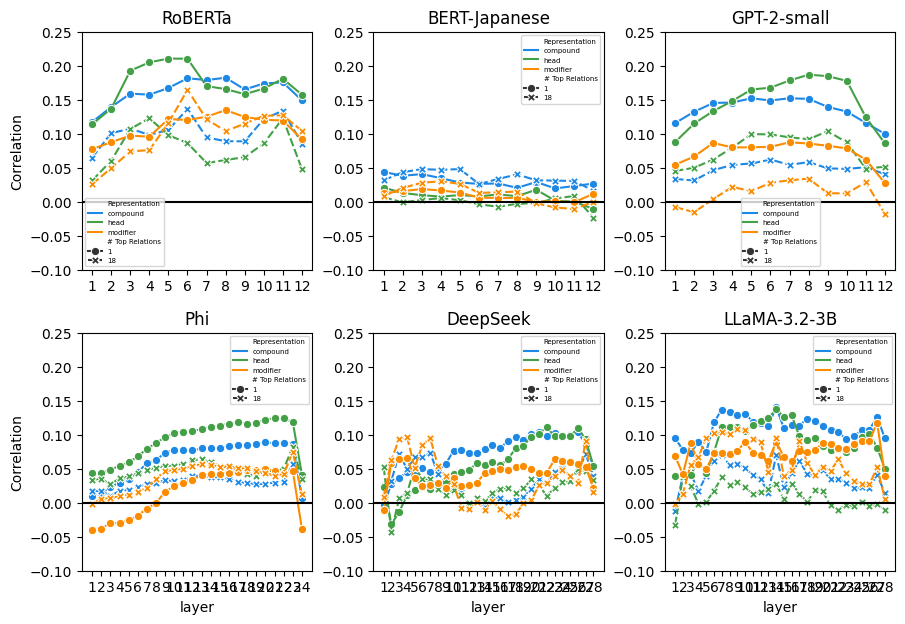

In [242]:
# Experiment 2a

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "compound": "#1E88E5",  # Blue
    "final_word": "#1E88E5",     # Blue
    "final_mod": "#FB8C00",      # Orange
    "modifier": "#FB8C00",  # Orange
    "final_head": "#43A047",     # Green
    "head": "#43A047"  # Green
}



fig_shape = (2, 3)

fig_df = finegrained_results_df.copy()

fig_df = sort_df_by_model_order(fig_df)
fig_df['Representation'] = fig_df['representation_name']
single_fig_size = 4
fig = plt.figure(figsize=(fig_shape[1] * 3.5, fig_shape[0] * 3.5, ))

grid_height = fig_shape[0] * single_fig_size
grid_width = fig_shape[1] * single_fig_size
grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=5)

for (i, model_df), (fig_y, fig_x) in zip(fig_df[(fig_df.condition=='_consider_magnitude') 
                                                                    & ((fig_df.num_top_relations_considered==1) | (fig_df.num_top_relations_considered==18))].groupby('model_order'), 
                                             product(range(fig_shape[0]), range(fig_shape[1]))):
#         model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
    model = model_df.iloc[0].model_name
    line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
    
    model_df = model_df.rename(columns={'num_top_relations_considered': '# Top Relations'})
    g = sns.lineplot(data=model_df, hue='Representation', y='relation_vector_corr', x='layer', style='# Top Relations', markers=True,palette = representation_colors, ax=line_plot_ax);
    line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)
    g.set(ylim=(-0.1, 0.25));

    if fig_x == 0:
        g.set_ylabel('Correlation');
    else:
        g.set_ylabel('');


    g.legend(loc = 'best', fontsize = 5)
    if fig_y == 0:
        g.set_xlabel('');

   
    g.axhline(0, color='black')

    g.set_title(model);
fig.show()

plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_original_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_original_deepseek_3B.eps', format='eps', bbox_inches='tight')

In [243]:
load = False

if load:
    finegrained_results_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_deepseek_final_word_avg_3B.csv')
else:
    representations = ['compound', 'head', 'modifier']
    representations2 = ['final_word', 'final_head', 'final_mod'] # Also whole_sentence

    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue


            for num_top_relations in range(1, 19):

                for condition in conditions:

                    if model_name in ['roberta-base', 'bert-base-japanese']:
                        for representation in representations:
                            
                            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))


                            
                            if representation == 'compound':
                                rdm = rsa_utils.get_rdm(reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])
                            elif representation == 'head':
                                rdm = rsa_utils.get_rdm(reps[:, 1, :][reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])
                            elif representation == 'modifier':
                                rdm = rsa_utils.get_rdm(reps[:, 0, :][reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])


                            reordered_relation_vector_rdm = rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] 
                            relation_vector_corr = corr(rdm, reordered_relation_vector_rdm)[0]

                            rows.append({'model': model_name, 'representation': representation, 'layer': layer, 'relation_vector_corr': relation_vector_corr, 'num_top_relations_considered': num_top_relations, "condition": condition})






                        
                    else:
                        for representation in representations2:
                            if representation == 'final_head':
                                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_head/{}_layer_{}_final_head_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            elif representation == 'final_mod':
                                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_mod/{}_layer_{}_final_mod_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            elif representation == 'final_word':
                                #reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                                reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                                reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_but_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                                reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_that_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                                reps = np.mean([reps_and, reps_but, reps_that], axis=0)


                            
                            
                            
                            rdm = rsa_utils.get_rdm(reps[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])

                            reordered_relation_vector_rdm = rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] 
                            
                            relation_vector_corr = corr(rdm, reordered_relation_vector_rdm)[0]

                            rows.append({'model': model_name, 'representation': representation, 'layer': layer, 'relation_vector_corr': relation_vector_corr, 'num_top_relations_considered': num_top_relations, "condition": condition})





    finegrained_results_df = pd.DataFrame(rows)
    finegrained_results_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_deepseek_final_word_avg_3B.csv')

roberta-base


100%|██████████| 28/28 [00:04<00:00,  6.42it/s]


bert-base-japanese


100%|██████████| 28/28 [00:04<00:00,  6.37it/s]


openai-community/gpt2


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


microsoft/phi-1


100%|██████████| 28/28 [00:29<00:00,  1.06s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [00:52<00:00,  1.86s/it]


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\3213657287.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


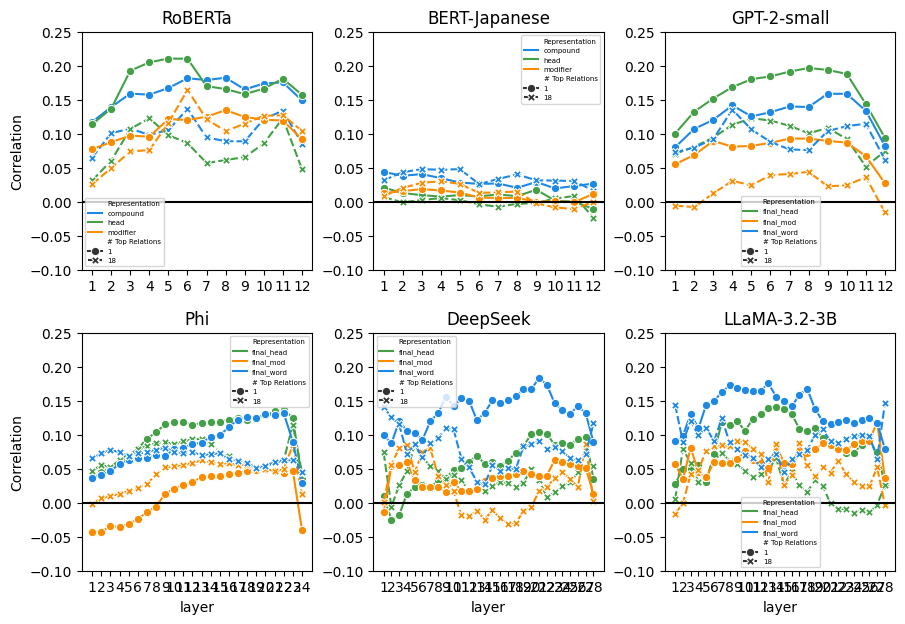

In [244]:
# Experiment 2a

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "compound": "#1E88E5",  # Blue
    "final_word": "#1E88E5",     # Blue
    "final_mod": "#FB8C00",      # Orange
    "modifier": "#FB8C00",  # Orange
    "final_head": "#43A047",     # Green
    "head": "#43A047"  # Green
}



fig_shape = (2, 3)

fig_df = finegrained_results_df.copy()

fig_df = sort_df_by_model_order(fig_df)
fig_df['Representation'] = fig_df['representation_name']
single_fig_size = 4
fig = plt.figure(figsize=(fig_shape[1] * 3.5, fig_shape[0] * 3.5, ))

grid_height = fig_shape[0] * single_fig_size
grid_width = fig_shape[1] * single_fig_size
grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=5)

for (i, model_df), (fig_y, fig_x) in zip(fig_df[(fig_df.condition=='_consider_magnitude') 
                                                                    & ((fig_df.num_top_relations_considered==1) | (fig_df.num_top_relations_considered==18))].groupby('model_order'), 
                                             product(range(fig_shape[0]), range(fig_shape[1]))):
#         model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
    model = model_df.iloc[0].model_name
    line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
    
    model_df = model_df.rename(columns={'num_top_relations_considered': '# Top Relations'})
    g = sns.lineplot(data=model_df, hue='Representation', y='relation_vector_corr', x='layer', style='# Top Relations', markers=True,palette = representation_colors, ax=line_plot_ax);
    line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)
    g.set(ylim=(-0.1, 0.25));

    if fig_x == 0:
        g.set_ylabel('Correlation');
    else:
        g.set_ylabel('');


    g.legend(loc = 'best', fontsize = 5)
    if fig_y == 0:
        g.set_xlabel('');

   
    g.axhline(0, color='black')

    g.set_title(model);
fig.show()

plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_deepseek_3B.eps', format='eps', bbox_inches='tight')

## 2B

In [245]:
load = False

if load:
    finegrained_results_df_2b = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_2b_deepseek_3B.csv')
else:
#     processing_conditions = ['Separate']
    processing_conditions = ['As a compound', 'In separate sentences']
    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            for num_top_relations in [1, 18]:

                for processing_condition in processing_conditions:
                    if processing_condition == 'As a compound':
                        reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        rdm = rsa_utils.get_rdm(reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, "_consider_magnitude")] , :])
                        
                    else:
                        raw_reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis/{}_layer_{}_compositional_analysis.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                        order = reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]
                        head_reps = raw_reps[[x for x in range(600) if x % 2 == 0], :][order]
                        mod_reps = raw_reps[[x for x in range(600) if x % 2 == 1], :][order]
                        reps = np.dstack((head_reps, mod_reps)).mean(axis=-1)
        
                        rdm = rsa_utils.get_rdm(reps)

                    reordered_relation_vector_rdm = rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] 
                    relation_vector_corr = corr(rdm, reordered_relation_vector_rdm)[0]

                    rows.append({'model': model_name, 'Word representations processed . . .': processing_condition, 'layer': layer, 'relation_vector_corr': relation_vector_corr, 'num_top_relations_considered': num_top_relations})

    finegrained_results_df_2b = pd.DataFrame(rows)
    finegrained_results_df_2b.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_2b_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [00:00<00:00, 53.14it/s]


bert-base-japanese


100%|██████████| 28/28 [00:00<00:00, 55.82it/s]


openai-community/gpt2


100%|██████████| 28/28 [00:01<00:00, 26.68it/s]


microsoft/phi-1


100%|██████████| 28/28 [00:04<00:00,  6.78it/s]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [00:03<00:00,  7.60it/s]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [00:06<00:00,  4.30it/s]


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\4062184002.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_order'] = [order_dict[x.model] for x in df.iloc]


same_relation_group_rdm_corr_within_compound_sentences


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\2447091099.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


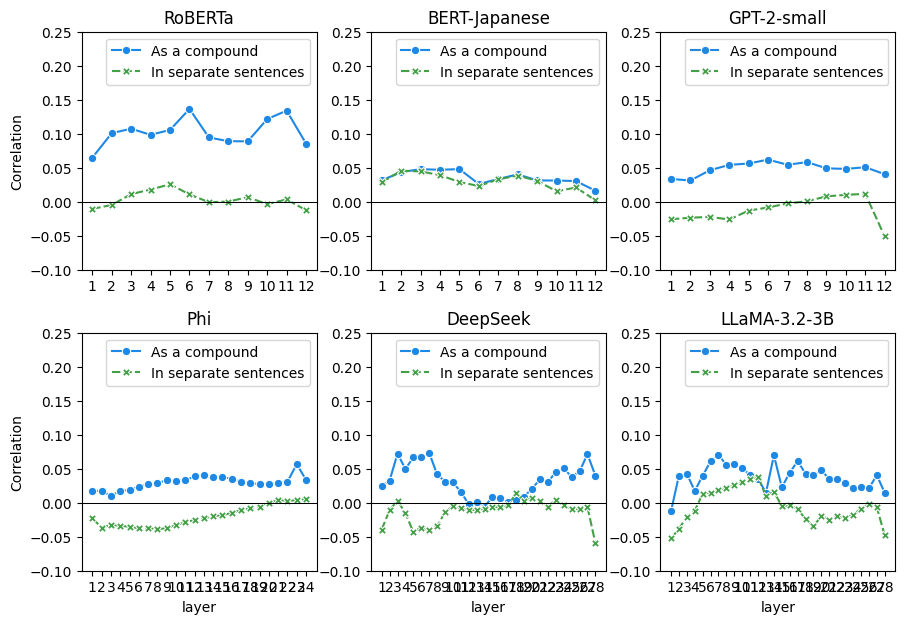

In [246]:
# Experiment 2b

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "As a compound": "#1E88E5",  # Blue
    "In separate sentences": "#43A047"  # Green
}


fig_shape = (2, 3)

print(y)
single_fig_size = 4
fig = plt.figure(figsize=(fig_shape[1] * 3.5, fig_shape[0] * 3.5, ))

grid_height = fig_shape[0] * single_fig_size
grid_width = fig_shape[1] * single_fig_size
grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)

figure_df = finegrained_results_df_2b[finegrained_results_df_2b.num_top_relations_considered==18]
# figure_df = finegrained_results_df
figure_df = sort_df_by_model_order(figure_df)

for (i, model_df), (fig_y, fig_x) in zip(figure_df.groupby('model_order'),product(range(fig_shape[0]), range(fig_shape[1]))):
#         model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
    model = model_df.iloc[0].model
    model_name = model_df.iloc[0].model_name
    
#     y_label = 'num_success'
    y_label = 'relation_vector_corr'
    
    line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
    g = sns.lineplot(data=model_df, hue='Word representations processed . . .', y=y_label, x='layer', style='Word representations processed . . .', markers=True, palette = representation_colors, ax=line_plot_ax);
    line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)


    g.set(ylim=(-0.1, 0.25))
    
    if fig_x == 0:
        #g.set_ylabel('Number of successes')
        g.set_ylabel('Correlation');
    else:
        g.set_ylabel('');

    if fig_y == 0:
        g.set_xlabel('');

    # if fig_x == 0 and fig_y == 0:
    #     g.legend(loc='best', bbox_to_anchor=(1.85, -2, 0.5, 0.5), ncol=1);
    # else:
    #     g.legend().remove();

    g.legend(loc='best');
#     line_plot_ax.axhline(num_tests, c='black', lw=0.75, linestyle='--')
#     line_plot_ax.axhline(num_tests/2, c='black', lw=0.75, linestyle='--')
    line_plot_ax.axhline(0, c='black', lw=0.75, linestyle='-')
#     line_plot_ax.axhline(0.5, c='black', lw=0.75, linestyle='--')
    
    g.set_title(model_name);
    
#     for layer in model_df.layer.unique():
#         pval = binom_diff_test_df[(binom_diff_test_df.model == model) & (binom_diff_test_df.layer == layer)]['corrected_p'].iloc[0]
#         x_offset =  0.075 if 'distil' in model else 0.2
#         y_offset = 0.1 - 0.035
        
#         if pval <= 0.05:
#             y = model_df[(model_df.layer==layer)]['% Successful Tests'].min()
#             plt.text(layer - x_offset, 0 - y_offset + 0.33, '*', weight='bold', size='x-large', color='black')
            
            
#             plt.text(layer - x_offset, 0 - y_offset + 0.585, '*', weight='bold', size='x-large', color='black')
    
fig.show()

# fig_name = 'figures/2_vs_2_compositional_test_alt'

# if without_lexical_confound:
#     fig_name += '_without_lexical_confound'

# print(y)
# if y_label == '% Successful Tests':
#     fig_name += '_percentage'

# print(fig_name)



plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_2b_original_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_2b_original_deepseek_3B.eps', format='eps', bbox_inches='tight')

In [247]:
load = False

if load:
    finegrained_results_df_2b = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_2b_deepseek_final_word_avg_3B.csv')
else:
#     processing_conditions = ['Separate']
    processing_conditions = ['As a compound', 'In separate sentences']
    rows = []

    corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
            
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            for num_top_relations in [1, 18]:

                for processing_condition in processing_conditions:
                    if processing_condition == 'As a compound':
                        if model_name in ['roberta-base', 'bert-base-japanese']:
                            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            rdm = rsa_utils.get_rdm(reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, "_consider_magnitude")] , :])
                        else:
                            #reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            
                            reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_but_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_that_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                            reps = np.mean([reps_and, reps_but, reps_that], axis=0)


                            
                            
                            
                            rdm = rsa_utils.get_rdm(reps[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, "_consider_magnitude")] , :])
                    else:
                        
                        if model_name in ['roberta-base', 'bert-base-japanese']:
                            raw_reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis/{}_layer_{}_compositional_analysis.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        else:
                            # reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_and.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            # reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_but.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                            # reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_that.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                            # raw_reps = np.mean([reps_and, reps_but, reps_that], axis=0)

                
                            
                            raw_reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_and.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        
                        
                        
                        
                        order = reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]
                        head_reps = raw_reps[[x for x in range(600) if x % 2 == 0], :][order]
                        mod_reps = raw_reps[[x for x in range(600) if x % 2 == 1], :][order]
                        reps = np.dstack((head_reps, mod_reps)).mean(axis=-1)
                        rdm = rsa_utils.get_rdm(reps)
                    


                    reordered_relation_vector_rdm = rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] 
                    relation_vector_corr = corr(rdm, reordered_relation_vector_rdm)[0]

                    rows.append({'model': model_name, 'Word representations processed . . .': processing_condition, 'layer': layer, 'relation_vector_corr': relation_vector_corr, 'num_top_relations_considered': num_top_relations})

    finegrained_results_df_2b = pd.DataFrame(rows)
    finegrained_results_df_2b.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_rsa_results_2b_deepseek_final_word_avg_3B.csv')

roberta-base


100%|██████████| 28/28 [00:00<00:00, 98.87it/s]


bert-base-japanese


100%|██████████| 28/28 [00:00<00:00, 99.45it/s]


openai-community/gpt2


100%|██████████| 28/28 [00:01<00:00, 18.57it/s]


microsoft/phi-1


100%|██████████| 28/28 [00:06<00:00,  4.51it/s]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [00:05<00:00,  4.92it/s]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [00:10<00:00,  2.68it/s]


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\4062184002.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_order'] = [order_dict[x.model] for x in df.iloc]
C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\1783407699.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


same_relation_group_rdm_corr_within_compound_sentences


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


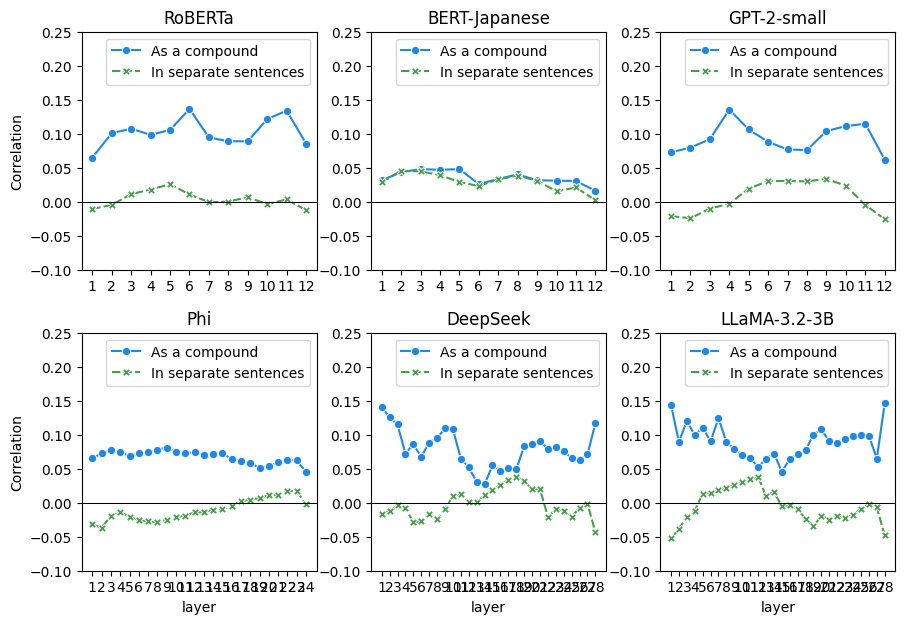

In [248]:
# Experiment 2b

# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "As a compound": "#1E88E5",  # Blue
    "In separate sentences": "#43A047"  # Green
}


fig_shape = (2, 3)

print(y)
single_fig_size = 4
fig = plt.figure(figsize=(fig_shape[1] * 3.5, fig_shape[0] * 3.5, ))

grid_height = fig_shape[0] * single_fig_size
grid_width = fig_shape[1] * single_fig_size
grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)

figure_df = finegrained_results_df_2b[finegrained_results_df_2b.num_top_relations_considered==18]
# figure_df = finegrained_results_df
figure_df = sort_df_by_model_order(figure_df)

for (i, model_df), (fig_y, fig_x) in zip(figure_df.groupby('model_order'),product(range(fig_shape[0]), range(fig_shape[1]))):
#         model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
    model = model_df.iloc[0].model
    model_name = model_df.iloc[0].model_name
    
#     y_label = 'num_success'
    y_label = 'relation_vector_corr'
    
    line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
    g = sns.lineplot(data=model_df, hue='Word representations processed . . .', y=y_label, x='layer', style='Word representations processed . . .', markers=True, palette = representation_colors, ax=line_plot_ax);
    line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)


    g.set(ylim=(-0.1, 0.25))
    
    if fig_x == 0:
        #g.set_ylabel('Number of successes')
        g.set_ylabel('Correlation');
    else:
        g.set_ylabel('');

    if fig_y == 0:
        g.set_xlabel('');

    # if fig_x == 0 and fig_y == 0:
    #     g.legend(loc='best', bbox_to_anchor=(1.85, -2, 0.5, 0.5), ncol=1);
    # else:
    #     g.legend().remove();

    g.legend(loc='best');
#     line_plot_ax.axhline(num_tests, c='black', lw=0.75, linestyle='--')
#     line_plot_ax.axhline(num_tests/2, c='black', lw=0.75, linestyle='--')
    line_plot_ax.axhline(0, c='black', lw=0.75, linestyle='-')
#     line_plot_ax.axhline(0.5, c='black', lw=0.75, linestyle='--')
    
    g.set_title(model_name);
    
#     for layer in model_df.layer.unique():
#         pval = binom_diff_test_df[(binom_diff_test_df.model == model) & (binom_diff_test_df.layer == layer)]['corrected_p'].iloc[0]
#         x_offset =  0.075 if 'distil' in model else 0.2
#         y_offset = 0.1 - 0.035
        
#         if pval <= 0.05:
#             y = model_df[(model_df.layer==layer)]['% Successful Tests'].min()
#             plt.text(layer - x_offset, 0 - y_offset + 0.33, '*', weight='bold', size='x-large', color='black')
            
            
#             plt.text(layer - x_offset, 0 - y_offset + 0.585, '*', weight='bold', size='x-large', color='black')
    
fig.show()

# fig_name = 'figures/2_vs_2_compositional_test_alt'

# if without_lexical_confound:
#     fig_name += '_without_lexical_confound'

# print(y)
# if y_label == '% Successful Tests':
#     fig_name += '_percentage'

# print(fig_name)



plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_2b_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/fine_grained_rsa_results_2b_deepseek_3B.eps', format='eps', bbox_inches='tight')

## SHARED WORDS

In [249]:
shares_word = lambda x, y: (x.split(' ')[0] == y.split(' ')[0]) or (x.split(' ')[0] == y.split(' ')[1]) or (x.split(' ')[1] == y.split(' ')[1])
result = [[shares_word(x, y) for y in compounds] for x in compounds]

pairs_with_shared_word = [(compounds[x[0]], compounds[x[1]]) for x in np.argwhere(np.array(result)) if x[0] > x[1]]

In [250]:
def word_cos_dist(reordered_reps, model, layer, plot=True):
    rows = []

    for i, compound_i in enumerate(compounds):
        for j, compound_j in enumerate(compounds):
            if i < j:
                compounds_share_word = shares_word(compound_i, compound_j)

                if 'deepseek' in model_name:
                    relation_vector_distance = cosine(reordered_reps[i].flatten(), reordered_reps[j].flatten())
                elif 'openai' in model_name:
                    relation_vector_distance = cosine(reordered_reps[i].flatten(), reordered_reps[j].flatten())
                elif 'llama' in model_name:
                    relation_vector_distance = cosine(reordered_reps[i].flatten(), reordered_reps[j].flatten())
                elif 'phi' in model_name:
                    relation_vector_distance = cosine(reordered_reps[i].flatten(), reordered_reps[j].flatten())

                else:
                
                    relation_vector_distance = cosine(reordered_reps[i], reordered_reps[j])

                rows.append({'model': model, 'layer': layer, 'i': i, 'compound_i': compound_i, 'j': j, 'compound_j': compound_j, 'shares_word': compounds_share_word,
                             'relation_vector_cosine_distance': relation_vector_distance})

    if plot:
        res = sns.distplot(compound_result_df[compound_result_df.shares_word==True].relation_vector_cosine_distance)
        res = sns.distplot(compound_result_df[compound_result_df.shares_word==False].relation_vector_cosine_distance)
        res.legend(['Pair shares a word', 'Pair does not share word'])
        res.set_ylabel('Density')
        res.set_xlabel('Cosine distance between relation vectors')
        res.set_title('Cosine distance between all pairs of 60 compounds')
                
    return pd.DataFrame(rows)
    



In [251]:
rows = []

for i, compound_i in enumerate(compounds):
    for j, compound_j in enumerate(compounds):
        if i < j:
            compounds_share_word = shares_word(compound_i, compound_j)
            
            relation_vector_distance = cosine(relation_vectors[i], relation_vectors[j])

            rows.append({'i': i, 'compound_i': compound_i, 'j': j, 'compound_j': compound_j, 'shares_word': compounds_share_word,
                         'relation_vector_cosine_distance': relation_vector_distance})
            
compound_result_df = pd.DataFrame(rows)
kl_div(compound_result_df[compound_result_df.shares_word==True].relation_vector_cosine_distance, compound_result_df[compound_result_df.shares_word==False].relation_vector_cosine_distance)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1765   NaN
1766   NaN
1767   NaN
1768   NaN
1769   NaN
Name: relation_vector_cosine_distance, Length: 1770, dtype: float64

C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\1251763133.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  res = sns.distplot(compound_result_df[compound_result_df.shares_word==True].relation_vector_cosine_distance)
C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\1251763133.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457a

Text(0.5, 1.0, 'Cosine distance between all pairs of 60 compounds')

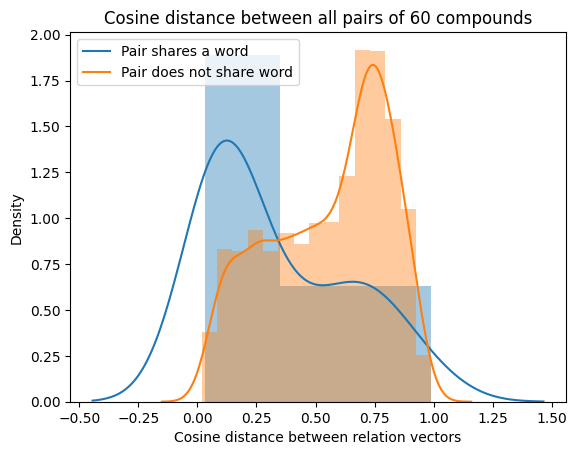

In [252]:
res = sns.distplot(compound_result_df[compound_result_df.shares_word==True].relation_vector_cosine_distance)
res = sns.distplot(compound_result_df[compound_result_df.shares_word==False].relation_vector_cosine_distance)
res.legend(['Pair shares a word', 'Pair does not share word'])
res.set_ylabel('Density')
res.set_xlabel('Cosine distance between relation vectors')
res.set_title('Cosine distance between all pairs of 60 compounds')

In [253]:
reduced_compounds = compounds

loop = True
while loop:
    rows = []

    for i, compound_i in enumerate(reduced_compounds):
        i_shares_head = 0
        i_shares_mod = 0
        for j, compound_j in enumerate(reduced_compounds):
            if i < j:
                compounds_share_word = shares_word(compound_i, compound_j)
                if compounds_share_word:
                    for num_word_i, word_i in enumerate(compound_i.split()):
                        for num_word_j, word_j in enumerate(compound_j.split()):
                            if word_i == word_j:
                                shared_word = word_i
                                if num_word_i == 0:
                                    i_shares_mod += 1
                                if num_word_i == 1:
                                    i_shares_head += 1

        rows.append({'i': i, 'compound': compound_i, 'num_mod_share': i_shares_mod, 'num_head_share': i_shares_head})

    compound_overlap_df = pd.DataFrame(rows)
    compound_overlap_df['total_overlap'] = compound_overlap_df['num_mod_share'] + compound_overlap_df['num_head_share']
    
    if compound_overlap_df[compound_overlap_df.total_overlap > 0].shape[0] > 0:
        compound_to_remove = compound_overlap_df[compound_overlap_df.total_overlap > 0].sort_values('total_overlap', ascending=False).iloc[0]['i']

        reduced_compounds = [x for (i, x) in enumerate(reduced_compounds) if i != compound_to_remove]
    else:
        loop = False

In [254]:
def filter_compounds(compounds):
    rows = []

    for i, compound_i in enumerate(compounds):
        for j, compound_j in enumerate(compounds):
            if i < j:
                compounds_share_word = shares_word(compound_i, compound_j)
                if compounds_share_word:
                    for word_i in compound_i.split():
                        for word_j in compound_j.split():
                            if word_i == word_j:
                                shared_word = word_i

                    rows.append({'i': i, 'compound_i': compound_i, 'j': j, 'compound_j': compound_j, 'shared_word': shared_word})

    shared_word_df = pd.DataFrame(rows)
    
    words_to_keep = []
    for (word, word_df) in shared_word_df.groupby('shared_word'):
        words_to_keep += [word_df.i.tolist()[0]]
    
    words_to_skip = [x for x in list(set(shared_word_df.i.tolist() + shared_word_df.j.tolist())) if x not in words_to_keep]
    
    compounds_to_keep = [x for i, x in enumerate(compounds) if i not in words_to_skip]
    
    return words_to_skip, compounds_to_keep, shared_word_df

In [255]:
words_to_skip, compounds_to_keep, shared_word_df = filter_compounds(compounds)
words_to_skip_two, compounds_to_keep_two, shared_word_df = filter_compounds(compounds_to_keep)
words_to_keep = np.array([np.argwhere(compounds == x)[0][0] for x in compounds_to_keep_two])
words_to_skip = np.array([x for x in range(60) if x not in words_to_keep])

In [256]:
filtered_original_inds_and_order = [x for i, x in enumerate(zip(original_inds, distance_from_least_dist)) if i in words_to_keep]

## 2 VS 2

In [257]:
def two_vs_two_test(rdm_x, rdm_y):
    ind_pairs = [x for x in permutations(range(len(rdm_x)), 2) if x[ 0] >= x[1]]
    
    outcomes = []
    for ind_pair in ind_pairs:
        outcomes.append(spearmanr(rdm_x[ind_pair[0]], rdm_y[ind_pair[0]])[0] + spearmanr(rdm_x[ind_pair[1]], rdm_y[ind_pair[1]])[0] > spearmanr(rdm_x[ind_pair[0]], rdm_y[ind_pair[1]])[0] + spearmanr(rdm_x[ind_pair[1]], rdm_y[ind_pair[0]])[0])

    return binomtest(sum(outcomes), len(ind_pairs)), sum(outcomes)


def two_vs_two_lin_reg_test(X, Y, save_predictions=False):
    ind_pairs = [x for x in permutations(range(len(X)), 2) if x[0] >= x[1]]
    
    if save_predictions:
        predictions_per_sample = np.zeros_like(Y, dtype=float)
    
    outcomes = []
    
    for ind_pair in ind_pairs:
        model = LinearRegression()

        train_inds = [x for x in range(60) if x not in ind_pair]
        
        
        
        model.fit(X[train_inds], Y[train_inds])

        preds = model.predict(X[ind_pair, :])
        
        if save_predictions:
            predictions_per_sample[ind_pair, :] += preds
        
        outcomes.append((cosine_similarity(preds[0].reshape(1, -1), Y[ind_pair[0]].reshape(1, -1)) 
                        + cosine_similarity(preds[1].reshape(1, -1), Y[ind_pair[1]].reshape(1, -1))
                        > cosine_similarity(preds[0].reshape(1, -1), Y[ind_pair[1]].reshape(1, -1))
                       + cosine_similarity(preds[1].reshape(1, -1), Y[ind_pair[0]].reshape(1, -1)))[0][0])
    
    if save_predictions:
        return binomtest(sum(outcomes), len(ind_pairs)), sum(outcomes), predictions_per_sample / (X.shape[0] - 1)
    else:
        return binomtest(sum(outcomes), len(ind_pairs)), sum(outcomes)

ind_pairs = [x for x in permutations(range(60), 2) if x[0] >= x[1]]
len(ind_pairs)

1770

In [258]:

load = False

if load:
    finegrained_binom_results_lin_reg_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_binom_lin_reg_deepseek_final_word_avg_3B.csv')
else:
    

    rows = []
    cos_rows = []
    num_top_relations = 18
    condition = '_consider_magnitude'
    
    prediction_dict = {}
    
    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
          
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            if model_name in ['roberta-base', 'bert-base-japanese']:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            else:
               
                #reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))

                reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_but_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_that_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                reps = np.mean([reps_and, reps_but, reps_that], axis=0)


                            


            if model_name in ['roberta-base', 'bert-base-japanese']:
                reordered_reps = reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]] 
            else:
                reordered_reps = reps[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]] 

            reordered_relation_vectors = reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)]

            binom_p_val, num_success, predictions = two_vs_two_lin_reg_test(reordered_reps, reordered_relation_vectors, save_predictions=True)
            rows.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})
            
   
            res_df = word_cos_dist(reordered_reps, model_name, layer, False)
            average_word_cos = res_df.relation_vector_cosine_distance.mean()
            does_not_share_word_cos = res_df[res_df.shares_word == False].relation_vector_cosine_distance.mean()
            shares_word_cos = res_df[res_df.shares_word == True].relation_vector_cosine_distance.mean()

            cos_rows.append({'model': model_name, 'layer': layer, "Condition": "All compounds", "Average distance": average_word_cos})
            cos_rows.append({'model': model_name, 'layer': layer, "Condition": "Compounds that share words", "Average distance": shares_word_cos})
            cos_rows.append({'model': model_name, 'layer': layer, "Condition": "Compounds that do not share words", "Average distance": does_not_share_word_cos})
    finegrained_binom_results_lin_reg_df = pd.DataFrame(rows)
    cos_rows_df = pd.DataFrame(cos_rows)
    finegrained_binom_results_lin_reg_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_binom_lin_reg_deepseek_final_word_avg_3B.csv')

roberta-base


100%|██████████| 28/28 [15:03<00:00, 32.26s/it] 


bert-base-japanese


100%|██████████| 28/28 [14:21<00:00, 30.77s/it] 


openai-community/gpt2


100%|██████████| 28/28 [11:18<00:00, 24.25s/it]


microsoft/phi-1


100%|██████████| 28/28 [30:41<00:00, 65.78s/it] 


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [40:45<00:00, 87.33s/it] 


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [1:09:06<00:00, 148.10s/it]


In [259]:
def two_vs_two_lin_reg_test_filter(X, Y, inds_to_keep, save_predictions=False):
    ind_pairs = [x for x in permutations([y for y in range(len(X)) if y in inds_to_keep], 2) if x[0] >= x[1]]
     
    if save_predictions:
        predictions_per_sample = np.zeros_like(Y, dtype=float)
    
    outcomes = []
    
    for ind_pair in ind_pairs:
        model = LinearRegression()

        train_inds = [x for x in [y for y in range(len(X)) if y in inds_to_keep] if x not in ind_pair]
        

        
        model.fit(X[train_inds], Y[train_inds])

        preds = model.predict(X[ind_pair, :])
        
        if save_predictions:
            predictions_per_sample[ind_pair, :] += preds
        
        outcomes.append((cosine_similarity(preds[0].reshape(1, -1), Y[ind_pair[0]].reshape(1, -1)) 
                        + cosine_similarity(preds[1].reshape(1, -1), Y[ind_pair[1]].reshape(1, -1))
                        > cosine_similarity(preds[0].reshape(1, -1), Y[ind_pair[1]].reshape(1, -1))
                       + cosine_similarity(preds[1].reshape(1, -1), Y[ind_pair[0]].reshape(1, -1)))[0][0])
    
    if save_predictions:
        return binomtest(sum(outcomes), len(ind_pairs)), sum(outcomes), predictions_per_sample / (X.shape[0] - 1)
    else:
        return binomtest(sum(outcomes), len(ind_pairs)), sum(outcomes)

original_ind_to_reordered_ind_map = {x: i for i, x in enumerate(reordered_compound_indices['{}{}'.format(num_top_relations, condition)])}
reordered_words_to_keep = [original_ind_to_reordered_ind_map[i] for i in words_to_keep]


In [260]:
# LEXICAL CONFOUND ADJUSTMENT
load = False

if load:
    finegrained_binom_results_without_lexical_confound_lin_reg_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_binom_results_without_lexical_confound_lin_reg_df_deepseek_final_word_avg_3B.csv')
else:
    

    rows = []

    num_top_relations = 18
    condition = '_consider_magnitude'
    
    prediction_dict = {}
    
    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
          
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            if model_name in ['roberta-base', 'bert-base-japanese']:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            else:
               
                #reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                
                reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_but_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_that_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                reps = np.mean([reps_and, reps_but, reps_that], axis=0)


                            




            if model_name in ['roberta-base', 'bert-base-japanese']:
                reordered_reps = reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]] 
            else:
                reordered_reps = reps[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]] 

            reordered_relation_vectors = reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)]

            binom_p_val, num_success, predictions = two_vs_two_lin_reg_test_filter(reordered_reps, reordered_relation_vectors, inds_to_keep=reordered_words_to_keep, 
                                                                                   save_predictions=True)
           
            prediction_dict['{}_{}'.format(model_name, layer)] = predictions

            rows.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})


    finegrained_binom_results_without_lexical_confound_lin_reg_df = pd.DataFrame(rows)
    finegrained_binom_results_without_lexical_confound_lin_reg_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_binom_results_without_lexical_confound_lin_reg_df_deepseek_final_word_avg_3B.csv')

roberta-base


100%|██████████| 28/28 [16:16<00:00, 34.86s/it]


bert-base-japanese


100%|██████████| 28/28 [05:53<00:00, 12.63s/it]


openai-community/gpt2


100%|██████████| 28/28 [06:50<00:00, 14.65s/it]


microsoft/phi-1


100%|██████████| 28/28 [12:42<00:00, 27.25s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [13:27<00:00, 28.83s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [15:58<00:00, 34.24s/it]


In [261]:
load = False

if load:
    finegrained_compositional_binom_results_lin_reg_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_df_deepseek_final_word_avg_3B.csv')    
    finegrained_compositional_binom_results_lin_reg_with_filter_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_with_filter_deepseek_final_word_avg_3B.csv')    
else:
    rows = []
    rows_without_lexical_compound = []

    num_top_relations = 18
    condition = '_consider_magnitude'

    prediction_dict = {}

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
          
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            if model_name in ['roberta-base', 'bert-base-japanese']:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis/{}_layer_{}_compositional_analysis.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
            else:

                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_and.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                
                # reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_and.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                # reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_but.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                # reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis_and/{}_layer_{}_compositional_analysis_that.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
                # reps = np.mean([reps_and, reps_but, reps_that], axis=0)

                


            order = reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]
            head_reps = reps[[x for x in range(600) if x % 2 == 0], :][order]
            mod_reps = reps[[x for x in range(600) if x % 2 == 1], :][order]
            compound_reps = np.dstack((head_reps, mod_reps)).mean(axis=-1)
            
            reordered_relation_vectors = reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)]

#             binom_p_val, num_success, predictions = two_vs_two_lin_reg_test(reordered_reps, reordered_relation_vectors, save_predictions=True)
            # mod is where i == 0, head where i == 1
            reordered_reps = compound_reps
                    
            binom_p_val, num_success, predictions = two_vs_two_lin_reg_test(reordered_reps, reordered_relation_vectors, save_predictions=True)

#           prediction_dict_head_mod['{}_{}_{}'.format(model_name, layer, rep)] = predictions

            rows.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})

            binom_p_val, num_success = two_vs_two_lin_reg_test_filter(reordered_reps, reordered_relation_vectors, inds_to_keep=reordered_words_to_keep, 
                                                                           save_predictions=False)
            rows_without_lexical_compound.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})
    
    finegrained_compositional_binom_results_lin_reg_df = pd.DataFrame(rows)
    finegrained_compositional_binom_results_lin_reg_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_df_deepseek_final_word_avg_3B.csv') 
    
    finegrained_compositional_binom_results_lin_reg_with_filter_df = pd.DataFrame(rows_without_lexical_compound)
    finegrained_compositional_binom_results_lin_reg_with_filter_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_with_filter_deepseek_final_word_avg_3B.csv') 

roberta-base


100%|██████████| 28/28 [14:40<00:00, 31.44s/it]


bert-base-japanese


100%|██████████| 28/28 [15:07<00:00, 32.41s/it]


openai-community/gpt2


100%|██████████| 28/28 [18:17<00:00, 39.20s/it] 


microsoft/phi-1


100%|██████████| 28/28 [35:34<00:00, 76.24s/it] 


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [32:33<00:00, 69.76s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [1:20:13<00:00, 171.89s/it]


In [262]:
finegrained_binom_results_lin_reg_df['Word representations processed . . .'] = 'As a compound'
finegrained_compositional_binom_results_lin_reg_df['Word representations processed . . .'] = 'In separate sentences'

finegrained_binom_results_without_lexical_confound_lin_reg_df['Word representations processed . . .'] = 'As a compound'
finegrained_compositional_binom_results_lin_reg_with_filter_df['Word representations processed . . .'] = 'In separate sentences'

without_lexical_confound = False

In [263]:
if without_lexical_confound:
    df_two = pd.concat([finegrained_binom_results_without_lexical_confound_lin_reg_df, finegrained_compositional_binom_results_lin_reg_with_filter_df])
    num_tests = 820
    random_baseline = 410
else:
    df_two = pd.concat([finegrained_compositional_binom_results_lin_reg_df, finegrained_binom_results_lin_reg_df])
    num_tests = 1770
    random_baseline = 1770 / 2
    
df_two = sort_df_by_model_order(df_two)


In [264]:
# together (iloc[1]) - separate (iloc[0])
res = [(x[0], np.mean([(y[-1].iloc[1].num_success - y[-1].iloc[0].num_success) / (y[-1].iloc[0].num_success) * 100 for y in x[-1].groupby('layer')])) for x in df_two.groupby('model')]
res 

[('bert-base-japanese', 0.016920062016282083),
 ('deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', -15.338146002112216),
 ('meta-llama/Llama-3.2-3B', -3.4915741073755444),
 ('microsoft/phi-1', -3.0135744394631643),
 ('openai-community/gpt2', -10.095857605504504),
 ('roberta-base', -10.535292640232052)]

In [265]:
# Tuples of percentage increase from processing together and max(num_successes_together, num_success_separate), for each layer of each model
nested_list = [[(y[-1].iloc[0].model, y[-1].iloc[0].layer, ((y[-1].iloc[1].num_success - y[-1].iloc[0].num_success) / (y[-1].iloc[0].num_success) * 100), max(y[-1].iloc[0].num_success, y[-1].iloc[1].num_success)) for y in x[-1].groupby('layer')] for x in df_two.groupby('model')]
flat_res = [y for x in nested_list for y in x]

In [266]:
model_map = {'bert-base-japanese': 'test',
             'microsoft/phi-1': 'dev',
             'roberta-base': 'none',
             'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B': 'dev',
             'meta-llama/Llama-3.2-3B': 'dev',
             'openai-community/gpt2': 'dev'}




In [267]:
flat_res = pd.DataFrame(flat_res, columns=['model', 'layer', 'percentage_increase', 'max_num_success'])

flat_res['model_type'] = [model_map[x.model] for x in flat_res.iloc]
flat_res['rdm_corr'] = relation_results_within_compound_groups_df.sort_values(['model', 'layer']).same_relation_group_rdm_corr_within_compound_sentences.tolist()

In [268]:
#finegrained_rsa_res = finegrained_results_df[(finegrained_results_df.condition == '_consider_magnitude') & (finegrained_results_df.num_top_relations_considered == 18) & (finegrained_results_df.representation == 'compound')]

finegrained_rsa_res = finegrained_results_df[
    (finegrained_results_df.condition == '_consider_magnitude') & 
    (finegrained_results_df.num_top_relations_considered == 18) & 
    (finegrained_results_df.representation.isin(['compound', 'final_word']))
]



flat_res['finegrained_rdm_corr'] = finegrained_rsa_res.sort_values(['model', 'layer']).relation_vector_corr.tolist()

In [269]:
for model, df in flat_res.groupby('model'):
    print(model, spearmanr(df.percentage_increase, df.finegrained_rdm_corr))

bert-base-japanese SignificanceResult(statistic=0.46153846153846156, pvalue=0.13094806950717278)
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B SignificanceResult(statistic=0.09688013136288998, pvalue=0.6238329434181382)
meta-llama/Llama-3.2-3B SignificanceResult(statistic=-0.08921729611384782, pvalue=0.651649431941635)
microsoft/phi-1 SignificanceResult(statistic=0.5826086956521739, pvalue=0.0028134524476631523)
openai-community/gpt2 SignificanceResult(statistic=0.20979020979020982, pvalue=0.5128409431818262)
roberta-base SignificanceResult(statistic=0.22377622377622378, pvalue=0.48445166145539886)


In [270]:
df = pd.DataFrame([{'model': m, 'correlation': spearmanr(df.percentage_increase, df.finegrained_rdm_corr)[0], 'p': spearmanr(df.percentage_increase, df.finegrained_rdm_corr)[1]} for m, df in flat_res.groupby('model')])
df.sort_values('correlation')

model  correlation         p
2                    meta-llama/Llama-3.2-3B    -0.089217  0.651649
1  deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B     0.096880  0.623833
4                      openai-community/gpt2     0.209790  0.512841
5                               roberta-base     0.223776  0.484452
0                         bert-base-japanese     0.461538  0.130948
3                            microsoft/phi-1     0.582609  0.002813

In [271]:
df_two[df_two.layer==1]

model  layer  \
0                                roberta-base      1   
0                                roberta-base      1   
12                         bert-base-japanese      1   
12                         bert-base-japanese      1   
24                      openai-community/gpt2      1   
24                      openai-community/gpt2      1   
36                            microsoft/phi-1      1   
36                            microsoft/phi-1      1   
60  deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B      1   
60  deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B      1   
88                    meta-llama/Llama-3.2-3B      1   
88                    meta-llama/Llama-3.2-3B      1   

                                          binom_p_val  num_success  \
0   BinomTestResult(k=1472, n=1770, alternative='t...         1472   
0   BinomTestResult(k=1319, n=1770, alternative='t...         1319   
12  BinomTestResult(k=1281, n=1770, alternative='t...         1281   
12  BinomTestResult(k=1277, n=1770, alternative='t...         1277   
24  BinomTestResult(k=1440, n=1770, alternative='t...         1440   
24  BinomTestResult(k=1294, n=1770, alternative='t...         1294   
36  BinomTestResult(k=1316, n=1770, alternative='t...         1316   
36  BinomTestResult(k=1274, n=1770, alternative='t...         1274   
60  BinomTestResult(k=1437, n=1770, alternative='t...         1437   
60  BinomTestResult(k=1258, n=1770, alternative='t...         1258   
88  BinomTestResult(k=1462, n=1770, alternative='t...         1462   
88  BinomTestResult(k=1361, n=1770, alternative='t...         1361   

   Word representations processed . . .  model_order     model_name  
0                         As a compound            0        RoBERTa  
0                 In separate sentences            0        RoBERTa  
12                        As a compound            1  BERT-Japanese  
12                In separate sentences            1  BERT-Japanese  
24                        As a compound            2    GPT-2-small  
24                In separate sentences            2    GPT-2-small  
36                        As a compound            3            Phi  
36                In separate sentences            3            Phi  
60                        As a compound            4       DeepSeek  
60                In separate sentences            4       DeepSeek  
88                        As a compound            5   LLaMA-3.2-3B  
88                In separate sentences            5   LLaMA-3.2-3B

In [272]:
df_rows = []

for (model, layer), rows in df_two.groupby(['model', 'layer']):
    processed_separately_num_success = rows.iloc[1].num_success
    processed_together_num_success = rows.iloc[0].num_success
    
    p = binomtest(processed_together_num_success, int(num_tests), processed_separately_num_success / num_tests, alternative='greater')
    
    df_rows.append({'model': model, 'layer': layer, 'p': p})

for i in range(13,29):
    
    df_rows.append({'model': 'bert-base-japanese', 'layer': i, 'p': -1})
    df_rows.append({'model': 'openai-community/gpt2', 'layer': i, 'p': -1})
    df_rows.append({'model': 'roberta-base', 'layer': i, 'p': -1})
for i in range(25,29):
    df_rows.append({'model' : "microsoft/phi-1", 'layer': i, 'p': -1})



binom_diff_test_df = pd.DataFrame(df_rows)

In [273]:
def extract_p_value(binom_result):
    if binom_result == -1:  # Handle cases where the value is -1
        return -1
    else:
        return binom_result.pvalue  # Extract p-value from BinomTestResult object

# Apply the function to the 'binom_p_val' column and create a new column 'pvalue'
binom_diff_test_df['pvalue'] = binom_diff_test_df['p'].apply(extract_p_value)

In [274]:
binom_diff_test_df['formatted_p'] = list(map(format_p_val, binom_diff_test_df.p))

In [275]:
if without_lexical_confound:
    finegrained_binom_results_lin_reg_df_formatted = finegrained_binom_results_without_lexical_confound_lin_reg_df.copy()
else:
    finegrained_binom_results_lin_reg_df_formatted = finegrained_binom_results_lin_reg_df.copy()

# Initialize an empty list to collect new rows
rows_to_add = []

for i in range(13,29):
   
    rows_to_add.append({'model': 'bert-base-japanese', 'layer': i, 'num_success': -1})
    rows_to_add.append({'model': 'openai-community/gpt2', 'layer': i, 'num_success': -1})
    rows_to_add.append({'model': 'roberta-base', 'layer': i, 'num_success': -1})
for i in range(25,29):
    df_rows.append({'model' : "microsoft/phi-1", 'layer': i, 'p': -1})


# Create a new DataFrame from the rows list
new_rows_df = pd.DataFrame(rows_to_add)

# Concatenate the new rows with the original DataFrame
finegrained_binom_results_lin_reg_df_formatted = pd.concat([finegrained_binom_results_lin_reg_df_formatted, new_rows_df], ignore_index=True)




In [276]:
finegrained_binom_results_lin_reg_df_formatted['formatted_num_success'] = [str(int(x)) if x > 0 else '-' for x in finegrained_binom_results_lin_reg_df_formatted.num_success]
finegrained_binom_results_lin_reg_df_formatted.pivot(index='model', columns='layer', values='formatted_num_success')

layer                                        1     2     3     4     5     6   \
model                                                                           
bert-base-japanese                         1281  1268  1294  1309  1305  1280   
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1437  1465  1502  1533  1507  1535   
meta-llama/Llama-3.2-3B                    1462  1505  1564  1560  1577  1566   
microsoft/phi-1                            1316  1290  1272  1264  1273  1277   
openai-community/gpt2                      1440  1503  1418  1460  1548  1590   
roberta-base                               1472  1505  1527  1527  1498  1525   

layer                                        7     8     9     10  ...    19  \
model                                                              ...         
bert-base-japanese                         1207  1178  1199  1298  ...     -   
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1628  1598  1574  1519  ...  1578   
meta-llama/Llama-3.2-3B                    1560  1561  1568  1551  ...  1521   
microsoft/phi-1                            1290  1303  1291  1277  ...  1343   
openai-community/gpt2                      1600  1558  1540  1505  ...     -   
roberta-base                               1533  1547  1585  1586  ...     -   

layer                                        20    21    22    23    24    25  \
model                                                                           
bert-base-japanese                            -     -     -     -     -     -   
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1594  1608  1590  1608  1542  1543   
meta-llama/Llama-3.2-3B                    1501  1498  1506  1499  1515  1530   
microsoft/phi-1                            1353  1349  1349  1335  1302   NaN   
openai-community/gpt2                         -     -     -     -     -     -   
roberta-base                                  -     -     -     -     -     -   

layer                                        26    27    28  
model                                                        
bert-base-japanese                            -     -     -  
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1524  1504  1398  
meta-llama/Llama-3.2-3B                    1527  1548  1396  
microsoft/phi-1                             NaN   NaN   NaN  
openai-community/gpt2                         -     -     -  
roberta-base                                  -     -     -  

[6 rows x 28 columns]

In [277]:
# p == -1 for distilroberta layers 7-12 (i.e. non-existent layers)
fdr_error_rate = 0.05 # default = 0.05
fdr_method = 'indep' # 'indep' or 'negcorr
binom_diff_test_df.loc[binom_diff_test_df.pvalue > -1, 'corrected_p'] = fdrcorrection(binom_diff_test_df[binom_diff_test_df.pvalue > -1].pvalue.tolist(), method=fdr_method, alpha=fdr_error_rate)[-1]
binom_diff_test_df.loc[binom_diff_test_df.pvalue == -1, 'corrected_p'] = -1
binom_diff_test_df['formatted_corrected_p']  = list(map(format_p_val, binom_diff_test_df.corrected_p))

In [278]:
df_two['% Successful Tests'] = df_two['num_success'] / num_tests

same_relation_group_rdm_corr_within_compound_sentences


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\784472914.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0.8084745762711865
figures/2_vs_2_compositional_test_alt_percentage


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


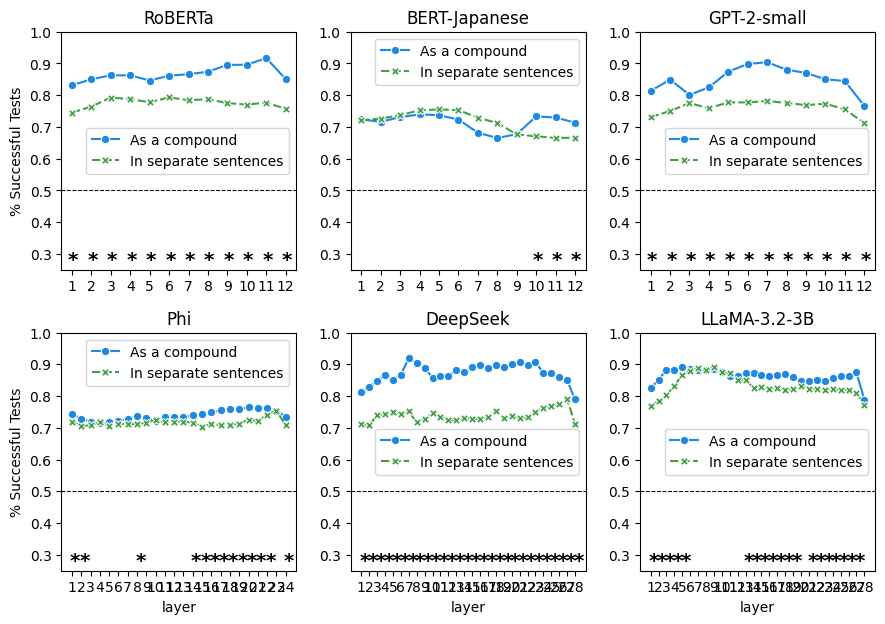

In [279]:
# Ex 3
# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "As a compound": "#1E88E5",  # Blue
    "In separate sentences": "#43A047"  # Green
}

fig_shape = (2, 3)

print(y)
single_fig_size = 4
fig = plt.figure(figsize=(fig_shape[1] * 3.5, fig_shape[0] * 3.5, ))

grid_height = fig_shape[0] * single_fig_size
grid_width = fig_shape[1] * single_fig_size
grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)

df_two = sort_df_by_model_order(df_two)

for (i, model_df), (fig_y, fig_x) in zip(df_two.groupby('model_order'),product(range(fig_shape[0]), range(fig_shape[1]))):
#         model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
    model = model_df.iloc[0].model
    model_name = model_df.iloc[0].model_name
    
#     y_label = 'num_success'
    y_label = '% Successful Tests'
    
    line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
    g = sns.lineplot(data=model_df, hue='Word representations processed . . .', y=y_label, x='layer', style='Word representations processed . . .', markers=True, palette = representation_colors,   ax=line_plot_ax);
    line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)

    if y_label == 'num_success':
        g.set(ylim=(y_lim))
    else:
#         g.set(ylim=(0, 1))
        g.set(ylim=(0.25, 1))
#         g.set(ylim=(0.5, 1))
    if fig_x == 0:
#         g.set_ylabel('Number of successes');
        g.set_ylabel('% Successful Tests');
    else:
        g.set_ylabel('');

    if fig_y == 0:
        g.set_xlabel('');

    # if fig_x == 0 and fig_y == 0:
    #     g.legend(loc='best', bbox_to_anchor=(1.85, -2, 0.5, 0.5), ncol=1);
    # else:
    #     g.legend().remove();

    g.legend(loc='best');
    
    line_plot_ax.axhline(num_tests, c='black', lw=0.75, linestyle='--')
    line_plot_ax.axhline(num_tests/2, c='black', lw=0.75, linestyle='--')
    line_plot_ax.axhline(0, c='black', lw=0.75, linestyle='-')
    line_plot_ax.axhline(0.5, c='black', lw=0.75, linestyle='--')
    
    g.set_title(model_name);
    
    for layer in model_df.layer.unique():
        pval = binom_diff_test_df[(binom_diff_test_df.model == model) & (binom_diff_test_df.layer == layer)]['corrected_p'].iloc[0]
        x_offset =  0.075 if 'distil' in model else 0.2
        y_offset = 0.1 - 0.035
        
        if pval <= 0.05:
            y = model_df[(model_df.layer==layer)]['% Successful Tests'].min()
            plt.text(layer - x_offset, 0 - y_offset + 0.33, '*', weight='bold', size='x-large', color='black')
#             plt.text(layer - x_offset, 0 - y_offset + 0.585, '*', weight='bold', size='x-large', color='black')
    
fig.show()

fig_name = 'figures/2_vs_2_compositional_test_alt'

if without_lexical_confound:
    fig_name += '_without_lexical_confound'

print(y)
if y_label == '% Successful Tests':
    fig_name += '_percentage'

print(fig_name)


plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/2_vs_2_experiment_3_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/2_vs_2_experiment_3_deepseek_3B.eps', format='eps', bbox_inches='tight')

## ORIGINAL 

In [280]:
load = False

if load:
    finegrained_binom_results_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_binom_deepseek_3B.csv')
else:
    whole_sentence = True

    rows = []

    num_top_relations = 18
    condition = '_consider_magnitude'

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
          
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            
            if whole_sentence:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds_mean_pooled/{}_layer_{}_noun_noun_compounds_mean_pooled.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            else:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))


            if whole_sentence:
                rdm = rsa_utils.get_rdm(reps[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])
            else:
                rdm = rsa_utils.get_rdm(reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)] , :])




            reordered_relation_vector_rdm = rdms_per_num_top_relations['{}{}'.format(num_top_relations, condition)] 

            binom_p_val, num_success = two_vs_two_test(rdm, reordered_relation_vector_rdm)

            rows.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})


    finegrained_binom_results_df = pd.DataFrame(rows)
    finegrained_binom_results_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_binom_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [00:48<00:00,  1.75s/it]


bert-base-japanese


100%|██████████| 28/28 [00:49<00:00,  1.79s/it]


openai-community/gpt2


100%|██████████| 28/28 [00:49<00:00,  1.78s/it]


microsoft/phi-1


100%|██████████| 28/28 [01:40<00:00,  3.59s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [01:56<00:00,  4.17s/it]


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [01:57<00:00,  4.19s/it]


In [281]:

load = False

if load:
    finegrained_binom_results_lin_reg_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_binom_lin_reg_deepseek_3B.csv')
else:
    whole_sentence = False

    rows = []
    cos_rows = []
    num_top_relations = 18
    condition = '_consider_magnitude'
    
    prediction_dict = {}
    
    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
          
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            if whole_sentence:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds_mean_pooled/{}_layer_{}_noun_noun_compounds_mean_pooled.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            else:
               
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))

            if whole_sentence:
                reordered_reps = reps[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]] 
            else:
                reordered_reps = reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]] 

            reordered_relation_vectors = reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)]

            binom_p_val, num_success, predictions = two_vs_two_lin_reg_test(reordered_reps, reordered_relation_vectors, save_predictions=True)
            rows.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})
            
   
            res_df = word_cos_dist(reordered_reps, model_name, layer, False)
            average_word_cos = res_df.relation_vector_cosine_distance.mean()
            does_not_share_word_cos = res_df[res_df.shares_word == False].relation_vector_cosine_distance.mean()
            shares_word_cos = res_df[res_df.shares_word == True].relation_vector_cosine_distance.mean()

            cos_rows.append({'model': model_name, 'layer': layer, "Condition": "All compounds", "Average distance": average_word_cos})
            cos_rows.append({'model': model_name, 'layer': layer, "Condition": "Compounds that share words", "Average distance": shares_word_cos})
            cos_rows.append({'model': model_name, 'layer': layer, "Condition": "Compounds that do not share words", "Average distance": does_not_share_word_cos})
    finegrained_binom_results_lin_reg_df = pd.DataFrame(rows)
    cos_rows_df = pd.DataFrame(cos_rows)
    finegrained_binom_results_lin_reg_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/relation_vector_binom_lin_reg_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [12:31<00:00, 26.82s/it]


bert-base-japanese


100%|██████████| 28/28 [13:21<00:00, 28.63s/it]


openai-community/gpt2


100%|██████████| 28/28 [13:35<00:00, 29.13s/it]


microsoft/phi-1


100%|██████████| 28/28 [38:15<00:00, 81.99s/it]  


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [39:19<00:00, 84.26s/it]  


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [58:43<00:00, 125.84s/it]


In [282]:
# LEXICAL CONFOUND ADJUSTMENT
load = False

if load:
    finegrained_binom_results_without_lexical_confound_lin_reg_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_binom_results_without_lexical_confound_lin_reg_df_deepseek_3B.csv')
else:
    whole_sentence = False

    rows = []

    num_top_relations = 18
    condition = '_consider_magnitude'
    
    prediction_dict = {}
    
    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
          
            
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue

            if whole_sentence:
                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds_mean_pooled/{}_layer_{}_noun_noun_compounds_mean_pooled.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            else:

                reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))


            reordered_reps = reps.mean(axis=1)[reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]] 
            

            reordered_relation_vectors = reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)]

            binom_p_val, num_success, predictions = two_vs_two_lin_reg_test_filter(reordered_reps, reordered_relation_vectors, inds_to_keep=reordered_words_to_keep, 
                                                                                   save_predictions=True)
           
            prediction_dict['{}_{}'.format(model_name, layer)] = predictions

            rows.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})


    finegrained_binom_results_without_lexical_confound_lin_reg_df = pd.DataFrame(rows)
    finegrained_binom_results_without_lexical_confound_lin_reg_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_binom_results_without_lexical_confound_lin_reg_df_deepseek_3B.csv')

roberta-base


100%|██████████| 28/28 [09:28<00:00, 20.32s/it]


bert-base-japanese


100%|██████████| 28/28 [05:42<00:00, 12.23s/it]


openai-community/gpt2


100%|██████████| 28/28 [10:10<00:00, 21.80s/it]


microsoft/phi-1


100%|██████████| 28/28 [16:25<00:00, 35.18s/it]


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [25:29<00:00, 54.64s/it] 


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [16:47<00:00, 35.99s/it]


In [283]:
load = False

if load:
    finegrained_compositional_binom_results_lin_reg_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_df_deepseek_3B.csv')    
    finegrained_compositional_binom_results_lin_reg_with_filter_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_with_filter_deepseek_3B.csv')    
else:
    rows = []
    rows_without_lexical_compound = []

    num_top_relations = 18
    condition = '_consider_magnitude'

    prediction_dict = {}

    for model_name in model_names:
        print(model_name)
        for layer in tqdm.tqdm(range(1, 29)):
          
            if layer > 12 and 'bert' in model_name:
                continue
            elif layer > 12 and 'xlm' in model_name:
                continue
            elif layer > 12 and 'xlnet' in model_name:
                continue
            elif layer > 12 and 'gpt' in model_name:
                continue
            elif layer > 24 and 'phi' in model_name:
                continue


            reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/compositional_analysis/{}_layer_{}_compositional_analysis.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
            order = reordered_orig_indices_per_top_relations['{}{}'.format(num_top_relations, condition)]
            head_reps = reps[[x for x in range(600) if x % 2 == 0], :][order]
            mod_reps = reps[[x for x in range(600) if x % 2 == 1], :][order]
            compound_reps = np.dstack((head_reps, mod_reps)).mean(axis=-1)
            
            reordered_relation_vectors = reordered_relation_vectors_dict['{}{}'.format(num_top_relations, condition)]

#             binom_p_val, num_success, predictions = two_vs_two_lin_reg_test(reordered_reps, reordered_relation_vectors, save_predictions=True)
            # mod is where i == 0, head where i == 1
            reordered_reps = compound_reps
                    
            binom_p_val, num_success, predictions = two_vs_two_lin_reg_test(reordered_reps, reordered_relation_vectors, save_predictions=True)

#           prediction_dict_head_mod['{}_{}_{}'.format(model_name, layer, rep)] = predictions

            rows.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})

            binom_p_val, num_success = two_vs_two_lin_reg_test_filter(reordered_reps, reordered_relation_vectors, inds_to_keep=reordered_words_to_keep, 
                                                                           save_predictions=False)
            rows_without_lexical_compound.append({'model': model_name, 'layer': layer, 'binom_p_val': binom_p_val, 'num_success': num_success})
    
    finegrained_compositional_binom_results_lin_reg_df = pd.DataFrame(rows)
    finegrained_compositional_binom_results_lin_reg_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_df_deepseek_3B.csv') 
    
    finegrained_compositional_binom_results_lin_reg_with_filter_df = pd.DataFrame(rows_without_lexical_compound)
    finegrained_compositional_binom_results_lin_reg_with_filter_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/finegrained_compositional_binom_results_lin_reg_with_filter_deepseek_3B.csv') 

roberta-base


100%|██████████| 28/28 [14:47<00:00, 31.70s/it]


bert-base-japanese


100%|██████████| 28/28 [14:03<00:00, 30.11s/it]


openai-community/gpt2


100%|██████████| 28/28 [24:28<00:00, 52.45s/it]  


microsoft/phi-1


100%|██████████| 28/28 [33:40<00:00, 72.17s/it] 


deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


100%|██████████| 28/28 [37:03<00:00, 79.39s/it] 


meta-llama/Llama-3.2-3B


100%|██████████| 28/28 [1:31:25<00:00, 195.92s/it]


In [284]:
finegrained_binom_results_lin_reg_df['Word representations processed . . .'] = 'As a compound'
finegrained_compositional_binom_results_lin_reg_df['Word representations processed . . .'] = 'In separate sentences'

finegrained_binom_results_without_lexical_confound_lin_reg_df['Word representations processed . . .'] = 'As a compound'
finegrained_compositional_binom_results_lin_reg_with_filter_df['Word representations processed . . .'] = 'In separate sentences'

without_lexical_confound = False

In [285]:
if without_lexical_confound:
    df_two = pd.concat([finegrained_binom_results_without_lexical_confound_lin_reg_df, finegrained_compositional_binom_results_lin_reg_with_filter_df])
    num_tests = 820
    random_baseline = 410
else:
    df_two = pd.concat([finegrained_compositional_binom_results_lin_reg_df, finegrained_binom_results_lin_reg_df])
    num_tests = 1770
    random_baseline = 1770 / 2
    
df_two = sort_df_by_model_order(df_two)


In [286]:
# together (iloc[1]) - separate (iloc[0])
res = [(x[0], np.mean([(y[-1].iloc[1].num_success - y[-1].iloc[0].num_success) / (y[-1].iloc[0].num_success) * 100 for y in x[-1].groupby('layer')])) for x in df_two.groupby('model')]
res 

[('bert-base-japanese', 0.016920062016282083),
 ('deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', -12.498975752907237),
 ('meta-llama/Llama-3.2-3B', -4.852652828667487),
 ('microsoft/phi-1', -8.64998110843746),
 ('openai-community/gpt2', -15.280216297779809),
 ('roberta-base', -10.535292640232052)]

In [287]:
# Tuples of percentage increase from processing together and max(num_successes_together, num_success_separate), for each layer of each model
nested_list = [[(y[-1].iloc[0].model, y[-1].iloc[0].layer, ((y[-1].iloc[1].num_success - y[-1].iloc[0].num_success) / (y[-1].iloc[0].num_success) * 100), max(y[-1].iloc[0].num_success, y[-1].iloc[1].num_success)) for y in x[-1].groupby('layer')] for x in df_two.groupby('model')]
flat_res = [y for x in nested_list for y in x]

In [288]:
# model_map = {'bert-base-japanese': 'test',
#              'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B': 'none',
#              'roberta-base': 'none',
#              'microsoft/phi-1': 'dev',
#              'meta-llama/Llama-3.2-3B': 'dev',
#              'openai-community/gpt2': 'dev'}




In [289]:
flat_res = pd.DataFrame(flat_res, columns=['model', 'layer', 'percentage_increase', 'max_num_success'])

flat_res['model_type'] = [model_map[x.model] for x in flat_res.iloc]
flat_res['rdm_corr'] = relation_results_within_compound_groups_df.sort_values(['model', 'layer']).same_relation_group_rdm_corr_within_compound_sentences.tolist()

In [290]:
#finegrained_rsa_res = finegrained_results_df[(finegrained_results_df.condition == '_consider_magnitude') & (finegrained_results_df.num_top_relations_considered == 18) & (finegrained_results_df.representation == 'compound')]

finegrained_rsa_res = finegrained_results_df[
    (finegrained_results_df.condition == '_consider_magnitude') & 
    (finegrained_results_df.num_top_relations_considered == 18) & 
    (finegrained_results_df.representation.isin(['compound', 'final_word']))
]



flat_res['finegrained_rdm_corr'] = finegrained_rsa_res.sort_values(['model', 'layer']).relation_vector_corr.tolist()

In [291]:
for model, df in flat_res.groupby('model'):
    print(model, spearmanr(df.percentage_increase, df.finegrained_rdm_corr))

bert-base-japanese SignificanceResult(statistic=0.46153846153846156, pvalue=0.13094806950717278)
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B SignificanceResult(statistic=-0.11932129173508485, pvalue=0.5453321466404526)
meta-llama/Llama-3.2-3B SignificanceResult(statistic=-0.14012041598248495, pvalue=0.47698278791468207)
microsoft/phi-1 SignificanceResult(statistic=0.19913043478260867, pvalue=0.3508987130768876)
openai-community/gpt2 SignificanceResult(statistic=0.16783216783216784, pvalue=0.602099427786538)
roberta-base SignificanceResult(statistic=0.22377622377622378, pvalue=0.48445166145539886)


In [292]:
df = pd.DataFrame([{'model': m, 'correlation': spearmanr(df.percentage_increase, df.finegrained_rdm_corr)[0], 'p': spearmanr(df.percentage_increase, df.finegrained_rdm_corr)[1]} for m, df in flat_res.groupby('model')])
df.sort_values('correlation')

model  correlation         p
2                    meta-llama/Llama-3.2-3B    -0.140120  0.476983
1  deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B    -0.119321  0.545332
4                      openai-community/gpt2     0.167832  0.602099
3                            microsoft/phi-1     0.199130  0.350899
5                               roberta-base     0.223776  0.484452
0                         bert-base-japanese     0.461538  0.130948

In [293]:
df_two[df_two.layer==1]

model  layer  \
0                                roberta-base      1   
0                                roberta-base      1   
12                         bert-base-japanese      1   
12                         bert-base-japanese      1   
24                      openai-community/gpt2      1   
24                      openai-community/gpt2      1   
36                            microsoft/phi-1      1   
36                            microsoft/phi-1      1   
60  deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B      1   
60  deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B      1   
88                    meta-llama/Llama-3.2-3B      1   
88                    meta-llama/Llama-3.2-3B      1   

                                          binom_p_val  num_success  \
0   BinomTestResult(k=1472, n=1770, alternative='t...         1472   
0   BinomTestResult(k=1319, n=1770, alternative='t...         1319   
12  BinomTestResult(k=1281, n=1770, alternative='t...         1281   
12  BinomTestResult(k=1277, n=1770, alternative='t...         1277   
24  BinomTestResult(k=1514, n=1770, alternative='t...         1514   
24  BinomTestResult(k=1297, n=1770, alternative='t...         1297   
36  BinomTestResult(k=1364, n=1770, alternative='t...         1364   
36  BinomTestResult(k=1258, n=1770, alternative='t...         1258   
60  BinomTestResult(k=1465, n=1770, alternative='t...         1465   
60  BinomTestResult(k=1235, n=1770, alternative='t...         1235   
88  BinomTestResult(k=1552, n=1770, alternative='t...         1552   
88  BinomTestResult(k=1361, n=1770, alternative='t...         1361   

   Word representations processed . . .  model_order     model_name  
0                         As a compound            0        RoBERTa  
0                 In separate sentences            0        RoBERTa  
12                        As a compound            1  BERT-Japanese  
12                In separate sentences            1  BERT-Japanese  
24                        As a compound            2    GPT-2-small  
24                In separate sentences            2    GPT-2-small  
36                        As a compound            3            Phi  
36                In separate sentences            3            Phi  
60                        As a compound            4       DeepSeek  
60                In separate sentences            4       DeepSeek  
88                        As a compound            5   LLaMA-3.2-3B  
88                In separate sentences            5   LLaMA-3.2-3B

In [294]:
df_rows = []

for (model, layer), rows in df_two.groupby(['model', 'layer']):
    processed_separately_num_success = rows.iloc[1].num_success
    processed_together_num_success = rows.iloc[0].num_success
    
    p = binomtest(processed_together_num_success, int(num_tests), processed_separately_num_success / num_tests, alternative='greater')
    
    df_rows.append({'model': model, 'layer': layer, 'p': p})

for i in range(13,29):

    df_rows.append({'model': 'bert-base-japanese', 'layer': i, 'p': -1})
    df_rows.append({'model': 'openai-community/gpt2', 'layer': i, 'p': -1})
    df_rows.append({'model': 'roberta-base', 'layer': i, 'p': -1})

for i in range(25,29): 
    df_rows.append({'model' : "microsoft/phi-1", 'layer': i, 'p': -1})

binom_diff_test_df = pd.DataFrame(df_rows)

In [295]:
def extract_p_value(binom_result):
    if binom_result == -1:  # Handle cases where the value is -1
        return -1
    else:
        return binom_result.pvalue  # Extract p-value from BinomTestResult object

# Apply the function to the 'binom_p_val' column and create a new column 'pvalue'
binom_diff_test_df['pvalue'] = binom_diff_test_df['p'].apply(extract_p_value)

In [296]:
binom_diff_test_df['formatted_p'] = list(map(format_p_val, binom_diff_test_df.p))

In [297]:
if without_lexical_confound:
    finegrained_binom_results_lin_reg_df_formatted = finegrained_binom_results_without_lexical_confound_lin_reg_df.copy()
else:
    finegrained_binom_results_lin_reg_df_formatted = finegrained_binom_results_lin_reg_df.copy()

# Initialize an empty list to collect new rows
rows_to_add = []

for i in range(13,29):
    
    rows_to_add.append({'model': 'bert-base-japanese', 'layer': i, 'num_success': -1})
    rows_to_add.append({'model': 'openai-community/gpt2', 'layer': i, 'num_success': -1})
    rows_to_add.append({'model': 'roberta-base', 'layer': i, 'num_success': -1})
for i in range(25,29):
    df_rows.append({'model' : "microsoft/phi-1", 'layer': i, 'p': -1})

# Create a new DataFrame from the rows list
new_rows_df = pd.DataFrame(rows_to_add)

# Concatenate the new rows with the original DataFrame
finegrained_binom_results_lin_reg_df_formatted = pd.concat([finegrained_binom_results_lin_reg_df_formatted, new_rows_df], ignore_index=True)



In [298]:
finegrained_binom_results_lin_reg_df_formatted['formatted_num_success'] = [str(int(x)) if x > 0 else '-' for x in finegrained_binom_results_lin_reg_df_formatted.num_success]
finegrained_binom_results_lin_reg_df_formatted.pivot(index='model', columns='layer', values='formatted_num_success')

layer                                        1     2     3     4     5     6   \
model                                                                           
bert-base-japanese                         1281  1268  1294  1309  1305  1280   
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1465  1431  1461  1498  1503  1534   
meta-llama/Llama-3.2-3B                    1552  1555  1555  1557  1558  1549   
microsoft/phi-1                            1364  1376  1389  1394  1397  1398   
openai-community/gpt2                      1514  1546  1561  1568  1568  1555   
roberta-base                               1472  1505  1527  1527  1498  1525   

layer                                        7     8     9     10  ...    19  \
model                                                              ...         
bert-base-japanese                         1207  1178  1199  1298  ...     -   
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1530  1522  1533  1521  ...  1526   
meta-llama/Llama-3.2-3B                    1558  1560  1576  1565  ...  1528   
microsoft/phi-1                            1376  1363  1364  1410  ...  1441   
openai-community/gpt2                      1543  1548  1541  1528  ...     -   
roberta-base                               1533  1547  1585  1586  ...     -   

layer                                        20    21    22    23    24    25  \
model                                                                           
bert-base-japanese                            -     -     -     -     -     -   
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1531  1509  1512  1517  1542  1519   
meta-llama/Llama-3.2-3B                    1556  1529  1521  1540  1543  1553   
microsoft/phi-1                            1425  1432  1433  1385  1393   NaN   
openai-community/gpt2                         -     -     -     -     -     -   
roberta-base                                  -     -     -     -     -     -   

layer                                        26    27    28  
model                                                        
bert-base-japanese                            -     -     -  
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  1489  1441  1465  
meta-llama/Llama-3.2-3B                    1545  1542  1488  
microsoft/phi-1                             NaN   NaN   NaN  
openai-community/gpt2                         -     -     -  
roberta-base                                  -     -     -  

[6 rows x 28 columns]

In [299]:
# p == -1 for distilroberta layers 7-12 (i.e. non-existent layers)
fdr_error_rate = 0.05 # default = 0.05
fdr_method = 'indep' # 'indep' or 'negcorr
binom_diff_test_df.loc[binom_diff_test_df.pvalue > -1, 'corrected_p'] = fdrcorrection(binom_diff_test_df[binom_diff_test_df.pvalue > -1].pvalue.tolist(), method=fdr_method, alpha=fdr_error_rate)[-1]
binom_diff_test_df.loc[binom_diff_test_df.pvalue == -1, 'corrected_p'] = -1
binom_diff_test_df['formatted_corrected_p']  = list(map(format_p_val, binom_diff_test_df.corrected_p))

In [300]:
df_two['% Successful Tests'] = df_two['num_success'] / num_tests

0.8084745762711865


C:\Users\40455223\AppData\Local\Temp\ipykernel_21676\1579151428.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0.772316384180791
figures/2_vs_2_compositional_test_alt_percentage


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


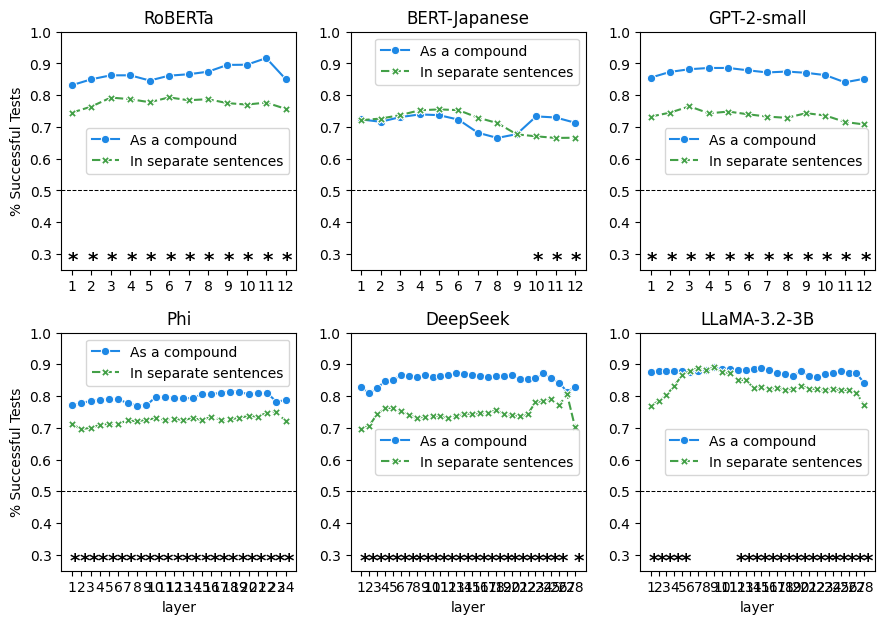

In [301]:
# Ex 3
# for y, ylim in zip(['same_relation_group_rdm_corr', 'same_relation_group_rdm_corr_within_compound_sentences', 'same_head_rdm_corr', 'same_head_rdm_corr_within_compound_sentences',
#          'same_modifier_rdm_corr', 'same_modifier_rdm_corr_within_compound_sentences'], [(0, 0.7), (0.2, 0.45), (0, 0.7), (0, 0.7), (0, 0.7), (0, 0.7)]):

representation_colors = {
    "As a compound": "#1E88E5",  # Blue
    "In separate sentences": "#43A047"  # Green
}

fig_shape = (2, 3)

print(y)
single_fig_size = 4
fig = plt.figure(figsize=(fig_shape[1] * 3.5, fig_shape[0] * 3.5, ))

grid_height = fig_shape[0] * single_fig_size
grid_width = fig_shape[1] * single_fig_size
grid = fig.add_gridspec(grid_height, grid_width, hspace=5, wspace=3)

df_two = sort_df_by_model_order(df_two)

for (i, model_df), (fig_y, fig_x) in zip(df_two.groupby('model_order'),product(range(fig_shape[0]), range(fig_shape[1]))):
#         model_df = sort_df_by_model_order(model_df)
#         print(model, fig_coords)
    model = model_df.iloc[0].model
    model_name = model_df.iloc[0].model_name
    
#     y_label = 'num_success'
    y_label = '% Successful Tests'
    
    line_plot_ax = fig.add_subplot(grid[fig_y*single_fig_size:fig_y*single_fig_size+single_fig_size, fig_x*single_fig_size:fig_x*single_fig_size+single_fig_size]);
    g = sns.lineplot(data=model_df, hue='Word representations processed . . .', y=y_label, x='layer', style='Word representations processed . . .', markers=True, palette = representation_colors,   ax=line_plot_ax);
    line_plot_ax.set_xticks(model_df.layer.unique());
#         g.set(ylim=)

    if y_label == 'num_success':
        g.set(ylim=(y_lim))
    else:
#         g.set(ylim=(0, 1))
        g.set(ylim=(0.25, 1))
#         g.set(ylim=(0.5, 1))
    if fig_x == 0:
#         g.set_ylabel('Number of successes');
        g.set_ylabel('% Successful Tests');
    else:
        g.set_ylabel('');

    if fig_y == 0:
        g.set_xlabel('');

    # if fig_x == 0 and fig_y == 0:
    #     g.legend(loc='best', bbox_to_anchor=(1.85, -2, 0.5, 0.5), ncol=1);
    # else:
    #     g.legend().remove();

    g.legend(loc='best');
    
    line_plot_ax.axhline(num_tests, c='black', lw=0.75, linestyle='--')
    line_plot_ax.axhline(num_tests/2, c='black', lw=0.75, linestyle='--')
    line_plot_ax.axhline(0, c='black', lw=0.75, linestyle='-')
    line_plot_ax.axhline(0.5, c='black', lw=0.75, linestyle='--')
    
    g.set_title(model_name);
    
    for layer in model_df.layer.unique():
        pval = binom_diff_test_df[(binom_diff_test_df.model == model) & (binom_diff_test_df.layer == layer)]['corrected_p'].iloc[0]
        x_offset =  0.075 if 'distil' in model else 0.2
        y_offset = 0.1 - 0.035
        
        if pval <= 0.05:
            y = model_df[(model_df.layer==layer)]['% Successful Tests'].min()
            plt.text(layer - x_offset, 0 - y_offset + 0.33, '*', weight='bold', size='x-large', color='black')
#             plt.text(layer - x_offset, 0 - y_offset + 0.585, '*', weight='bold', size='x-large', color='black')
    
fig.show()

fig_name = 'figures/2_vs_2_compositional_test_alt'

if without_lexical_confound:
    fig_name += '_without_lexical_confound'

print(y)
if y_label == '% Successful Tests':
    fig_name += '_percentage'

print(fig_name)


plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/2_vs_2_experiment_3_original_deepseek_3B.png', bbox_inches='tight')
plt.savefig('E:/NOUN-NOUN-COMPOUNDS-V1/files/figures/2_vs_2_experiment_3_original_deepseek_3B.eps', format='eps', bbox_inches='tight')

In [302]:
# # Using a heatmap to visualise the correlation for the representation of the correlation for each layer

# load = False

# if load:
#     relation_results_within_compound_groups_per_word_df = pd.read_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_3B_final_word_tokens_heatmap.csv')
    
#     with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/compound_correlation_dict_final_word_heatmap.pkl', 'rb') as f:
#         compound_correlation_dict = pickle.load(f)
    
# else:
#     rows = []
#     i = 0
#     corr = lambda x, y: rsa_utils.correlate_rdms(x, y, correlation=corr_metric)
#     #representations = ["final_word", "final_head", "final_mod", "first_head", "first_mod"]
#     representations = ["first_mod", "final_mod", "first_head", "final_head", "final_word"]
#     compound_correlation_dict = {}
    
#     for model_name in model_names:
#         print(model_name)
#         for layer in tqdm.tqdm(range(1, 29)):
            
#             if layer > 12 and 'bert' in model_name:
#                 continue
#             elif layer > 12 and 'xlm' in model_name:
#                 continue
#             elif layer > 12 and 'xlnet' in model_name:
#                 continue
#             elif layer > 12 and 'gpt' in model_name:
#                 continue
#             elif layer > 24 and 'phi' in model_name:
#                 continue

            
#             if model_name in ['roberta-base', 'bert-base-japanese']:

#                 reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/noun_noun_compounds/{}_layer_{}_noun_noun_compounds.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
#                 compound_rdm = rsa_utils.get_rdm(reps.mean(axis=1)[paraphrase_inds])
#                 head_noun_rdm = rsa_utils.get_rdm(reps[:, 1, :].squeeze()[paraphrase_inds])
#                 mod_word_rdm = rsa_utils.get_rdm(reps[:, 0, :].squeeze()[paraphrase_inds])

#                 for rdm_name, rdm in [('compound_mean', compound_rdm), ('head_noun_mean', head_noun_rdm), ('mod_word_mean', mod_word_rdm)]:

#                     row = {'model': model_name, 'layer': layer, 'representation': rdm_name}

#                     for target_rdm_name, target_rdm in group_rdms_to_correlate:
#                         second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'
#                         res, corrs = rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already,
#                                                                                           keep_corrs=True)
#                         row = {**row, **res}
                    
#                         if target_rdm_name == 'same_relation_group_rdm' and 'compound' in rdm_name:
#                             compound_correlation_dict['{}_{}'.format(model_name, layer)] = corrs 
                    
#                         rows.append(row)




#             elif model_name in ['openai-community/gpt2', 'microsoft/phi-1', 'meta-llama/Llama-3.2-3B', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B']:
                
            
#                 for rep in representations:
                
#                     if rep == "first_mod":
#                         reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_mod/{}_layer_{}_first_mod_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                    

#                     elif rep == "final_mod":
                    
#                         reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_mod/{}_layer_{}_final_mod_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                    
#                     elif rep == "first_head":
#                         reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_head/{}_layer_{}_first_head_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                    
#                     elif rep == "final_head":
                    
#                         reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_head/{}_layer_{}_final_head_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
                        
#                     elif rep == 'final_word':
                    
#                         #reps = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
#                         reps_and = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_word_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
#                         reps_but = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_but_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
#                         reps_that = np.load('E:/NOUN-NOUN-COMPOUNDS-V1/data/representations/{}/layer_{}/final_word/{}_layer_{}_final_that_tokens.npy'.format(model_name.split('-')[0], layer, model_name, layer))
            
#                         reps = np.mean([reps_and, reps_but, reps_that], axis=0)


                    
                      
#                     rdm = rsa_utils.get_rdm(reps[paraphrase_inds])
#                     row = {'model': model_name, 'layer': layer, 'representation': rep}

#                     for target_rdm_name, target_rdm in group_rdms_to_correlate:
#                         second_rdm_group_level_already = target_rdm_name == 'same_relation_group_rdm'

#                         res, corrs = rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already,
#                                                                                           corr_metric=corr_metric, keep_corrs=True)

#                         row = {**row, **res}
#                         #row = {**row, **rsa_utils.correlate_over_groups_and_get_row_values(rdm, target_rdm, target_rdm_name, second_rdm_group_level_already=second_rdm_group_level_already, corr_metric=corr_metric)}
                        
#                         if target_rdm_name == 'same_relation_group_rdm' and rep == 'final_word':
#                             compound_correlation_dict['{}_{}'.format(model_name, layer)] = corrs 
                        
#                         rows.append(row)
                
                
                
            

                
                

#     with open('E:/NOUN-NOUN-COMPOUNDS-V1/files/compound_correlation_dict_final_word_heatmap.pkl', 'wb') as f:
#         pickle.dump(compound_correlation_dict, f, pickle.HIGHEST_PROTOCOL)
        
#     relation_results_within_compound_groups_per_word_df = pd.DataFrame(rows)
#     relation_results_within_compound_groups_per_word_df.to_csv('E:/NOUN-NOUN-COMPOUNDS-V1/data/results/nn_compound_transformer_relations_per_word_deepseek_3B_final_word_tokens_heatmap.csv')


In [303]:

# # Filter data for GPT-2
# gpt2_data = relation_results_within_compound_groups_per_word_df[
#     relation_results_within_compound_groups_per_word_df['model'] == 'openai-community/gpt2'
# ]

# # Pivot the data for heatmap
# heatmap_data = gpt2_data.pivot_table(
#     index='layer',
#     columns='representation',
#     values='same_relation_group_rdm_corr_within_compound_sentences',  # Replace with the actual column name for correlation values
#     aggfunc='mean'  # Ensure you aggregate if duplicates exist
# )


# desired_order = ["first_mod", "final_mod", "first_head", "final_head", "final_word"]

# # Reorder the columns
# heatmap_data = heatmap_data[desired_order]



# # Plot heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     heatmap_data,
#     cmap='coolwarm',  # Color scheme for correlations
#     annot=True,       # Display values on the heatmap
#     fmt=".2f",        # Format for annotation
#     cbar_kws={'label': 'Correlation'}
# )

# # Customize the plot
# plt.title('GPT2 Correlation Heatmap', fontsize=16)
# plt.xlabel('Word Representation', fontsize=12)
# plt.ylabel('Layer', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Save or display the plot
# plt.savefig('gpt2_correlation.png', format = 'png')
# plt.savefig('gpt2_correlation.eps', format='eps')
# plt.show()


In [304]:

# # Filter data for GPT-2
# gpt2_data = relation_results_within_compound_groups_per_word_df[
#     relation_results_within_compound_groups_per_word_df['model'] == 'microsoft/phi-1'
# ]

# # Pivot the data for heatmap
# heatmap_data = gpt2_data.pivot_table(
#     index='layer',
#     columns='representation',
#     values='same_relation_group_rdm_corr_within_compound_sentences',  # Replace with the actual column name for correlation values
#     aggfunc='mean'  # Ensure you aggregate if duplicates exist
# )


# desired_order = ["first_mod", "final_mod", "first_head", "final_head", "final_word"]

# # Reorder the columns
# heatmap_data = heatmap_data[desired_order]



# # Plot heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     heatmap_data,
#     cmap='coolwarm',  # Color scheme for correlations
#     annot=True,       # Display values on the heatmap
#     fmt=".2f",        # Format for annotation
#     cbar_kws={'label': 'Correlation'}
# )

# # Customize the plot
# plt.title('Phi-1 Correlation Heatmap', fontsize=16)
# plt.xlabel('Word Representation', fontsize=12)
# plt.ylabel('Layer', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Save or display the plot
# plt.savefig('phi_correlation.png', format = 'png')
# plt.savefig('phi_correlation.eps', format='eps')
# plt.show()


In [305]:

# # Filter data for GPT-2
# gpt2_data = relation_results_within_compound_groups_per_word_df[
#     relation_results_within_compound_groups_per_word_df['model'] == 'meta-llama/Llama-3.2-3B'
# ]

# # Pivot the data for heatmap
# heatmap_data = gpt2_data.pivot_table(
#     index='layer',
#     columns='representation',
#     values='same_relation_group_rdm_corr_within_compound_sentences',  # Replace with the actual column name for correlation values
#     aggfunc='mean'  # Ensure you aggregate if duplicates exist
# )


# desired_order = ["first_mod", "final_mod", "first_head", "final_head", "final_word"]

# # Reorder the columns
# heatmap_data = heatmap_data[desired_order]



# # Plot heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     heatmap_data,
#     cmap='coolwarm',  # Color scheme for correlations
#     annot=True,       # Display values on the heatmap
#     fmt=".2f",        # Format for annotation
#     cbar_kws={'label': 'Correlation'}
# )

# # Customize the plot
# plt.title('LLaMA 3.2 Correlation Heatmap', fontsize=16)
# plt.xlabel('Word Representation', fontsize=12)
# plt.ylabel('Layer', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Save or display the plot
# plt.savefig('llama_correlation.png', format = 'png')
# plt.savefig('llama_correlation.eps', format='eps')
# plt.show()


In [306]:

# # Filter data for GPT-2
# gpt2_data = relation_results_within_compound_groups_per_word_df[
#     relation_results_within_compound_groups_per_word_df['model'] == 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
# ]

# # Pivot the data for heatmap
# heatmap_data = gpt2_data.pivot_table(
#     index='layer',
#     columns='representation',
#     values='same_relation_group_rdm_corr_within_compound_sentences',  # Replace with the actual column name for correlation values
#     aggfunc='mean'  # Ensure you aggregate if duplicates exist
# )


# desired_order = ["first_mod", "final_mod", "first_head", "final_head", "final_word"]

# # Reorder the columns
# heatmap_data = heatmap_data[desired_order]



# # Plot heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     heatmap_data,
#     cmap='coolwarm',  # Color scheme for correlations
#     annot=True,       # Display values on the heatmap
#     fmt=".2f",        # Format for annotation
#     cbar_kws={'label': 'Correlation'}
# )

# # Customize the plot
# plt.title('DeepSeek-R1 Correlation Heatmap', fontsize=16)
# plt.xlabel('Word Representation', fontsize=12)
# plt.ylabel('Layer', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Save or display the plot
# plt.savefig('deepseek_correlation.png', format = 'png')
# plt.savefig('deepseek_correlation.eps', format='eps')
# plt.show()
